# Data Mining for Online Retail Transcation

## Objective

This notebook represents a case study of using data mining techniques inCustomer-centric business intelligence for an online retailer. This is presented to help the business better understand its customers and therefore conduct customer-centric marketing.
- Who are the most/least valuable customers to the business? What are the distinct characteristics of them?
- Who are the most/least loyal customers, and how are they characterized?
- What are customers’ purchase behaviour patterns? Which products/items have customers purchased together often? In which sequence the products have been purchased?
- What are the sales patterns in terms of various perspectives such as products/items, regions and time (weekly, monthly, quarterly, yearly and seasonally), and so on?

## Dataset

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Variable information:
- **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.	
- **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
- **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal, the name of the country where each customer resides. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import re
from collections import defaultdict, Counter
from itertools import combinations
from scipy import stats

# For Market Basket Analysis
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# For CLV
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time

RSEED = 42


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# data (as pandas dataframes) 
df_retail = online_retail.data.original 

# metadata 
print(online_retail.metadata) 
  
# variable information 
print(online_retail.variables) 

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [3]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Missing value
print(df_retail.isnull().sum())

# There are 135k customerID missing and that is the important feature for clustering.
# We can assume that 135k customers are non-member.

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## Feature Engineering

In [6]:
# Ensure the data is in the right format
df_retail[['InvoiceNo','StockCode','Description','CustomerID','Country']] = df_retail[['InvoiceNo','StockCode','Description','CustomerID','Country']].astype(str)
df_retail['Quantity'] = df_retail['Quantity'].astype(int)
df_retail['UnitPrice'] = df_retail['UnitPrice'].astype(float)

In [7]:
# Creating amount columns
df_retail['Amount'] = df_retail['Quantity']*df_retail['UnitPrice']

#### Remove Outlier

In [8]:
## REMOVE OUTLIERS using Z-score
# Since the data is mixed between wholesellers' transactions and regular customers transactions.

outlier_customers = set()
outlier_transactions = set()

# Customer-level aggregations
customer_stats = df_retail.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',           # Number of orders
    'Quantity': ['sum', 'mean', 'std', 'max'],  # Quantity patterns
    'Amount': ['sum', 'mean', 'std', 'max'],    # Spending patterns
    'StockCode': 'nunique',           # Product diversity
    'InvoiceDate': ['min', 'max']     # Time span
}).round(2)

customer_stats.columns = [
    'total_orders', 'total_quantity', 'avg_quantity_per_item', 'std_quantity', 'max_quantity',
    'total_spending', 'avg_spending_per_item', 'std_spending', 'max_spending',
    'unique_products', 'first_purchase', 'last_purchase'
]


# Additional metrics
customer_stats['avg_order_value'] = customer_stats['total_spending'] / customer_stats['total_orders']
customer_stats['avg_quantity_per_order'] = customer_stats['total_quantity'] / customer_stats['total_orders']
customer_stats['products_per_order'] = customer_stats['unique_products'] / customer_stats['total_orders']
        

customer_stats = customer_stats.fillna(0)
customer_stats.head()


,total_orders,total_quantity,avg_quantity_per_item,std_quantity,max_quantity,total_spending,avg_spending_per_item,std_spending,max_spending,unique_products,first_purchase,last_purchase,avg_order_value,avg_quantity_per_order,products_per_order
CustomerID,,,,,,,,,,,,,,,
12346.0,2,0,0.00,104955.86,74215,0.00,0.00,109154.09,77183.6,1,1/18/2011 10:01,1/18/2011 10:17,0.000000,0.000000,0.500000
12347.0,7,2458,13.51,18.86,240,4310.00,23.68,23.29,249.6,103,1/26/2011 14:30,8/2/2011 8:48,615.714286,351.142857,14.714286
12348.0,4,2341,75.52,51.09,144,1797.24,57.98,48.51,240.0,22,1/25/2011 10:42,9/25/2011 13:13,449.310000,585.250000,5.500000
12349.0,1,631,8.64,6.98,36,1757.55,24.08,34.66,300.0,73,11/21/2011 9:51,11/21/2011 9:51,1757.550000,631.000000,73.000000
12350.0,1,197,11.59,4.35,24,334.40,19.67,7.28,40.0,17,2/2/2011 16:01,2/2/2011 16:01,334.400000,197.000000,17.000000


In [9]:
z_threshold = 2
metrics = ['total_quantity', 'total_spending', 'avg_order_value', 'max_quantity']

z_scores = pd.DataFrame(index=customer_stats.index)
for metric in metrics:
    z_scores[f'{metric}_zscore'] = np.abs(
        stats.zscore(customer_stats[metric], nan_policy="omit")
    )

# Customers with high Z-scores in any metric --> masking
outlier_mask = (z_scores > z_threshold).any(axis=1)
statistical_outliers = customer_stats[outlier_mask].index.tolist()

print(f"Z-score outliers by metric:")
for metric in metrics:
    count = (z_scores[f'{metric}_zscore'] > z_threshold).sum()
    print(f"  - {metric}: {count} customers")

print(f"Total statistical outliers: {len(statistical_outliers)} customers ({len(statistical_outliers)/len(customer_stats)*100:.1f}%)")

outlier_customers.update(statistical_outliers)

Z-score outliers by metric:
  - total_quantity: 33 customers
  - total_spending: 19 customers
  - avg_order_value: 122 customers
  - max_quantity: 7 customers
Total statistical outliers: 142 customers (3.2%)


In [10]:
X = df_retail[~df_retail['CustomerID'].isin(outlier_customers)]

print(f"Clean dataset: {X.shape[0]:,} rows, {X.shape[1]} columns")

# Calculate impact
removed_revenue = df_retail[df_retail['CustomerID'].isin(outlier_customers)]['Amount'].sum()
total_revenue = df_retail['Amount'].sum()

print(f"Removed revenue: {removed_revenue:,.2f} ({removed_revenue/total_revenue*100:.1f}% of total)")

Clean dataset: 354,733 rows, 9 columns
Removed revenue: 4,179,322.03 (42.9% of total)


In [11]:
# Define Members for those who has and has not CustomerID

X['Members'] = X['CustomerID'].notna().astype(int)

C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\3236557009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Members'] = X['CustomerID'].notna().astype(int)


In [12]:
X['InvoiceDate'] = pd.to_datetime(X['InvoiceDate'], errors='coerce')

X['Year'] = X['InvoiceDate'].dt.year
X['Month'] = X['InvoiceDate'].dt.month
X['Day'] = X['InvoiceDate'].dt.day
X['Hour'] = X['InvoiceDate'].dt.hour
X['Min'] = X['InvoiceDate'].dt.minute

C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\4282361862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['InvoiceDate'] = pd.to_datetime(X['InvoiceDate'], errors='coerce')
C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\4282361862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Year'] = X['InvoiceDate'].dt.year
C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\4282361862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [13]:
# Check for negative values in Quantity and UnitPrice
X_negative = X[((X['Quantity']<=0) | (X['UnitPrice']<=0))]
print(X_negative.count())
print("="*50)
print(X_negative.head())

# There are 11,805 rows that contains negative values. Some of it come from "cancelled" order.

InvoiceNo      7590
StockCode      7590
Description    7590
Quantity       7590
InvoiceDate    7590
UnitPrice      7590
CustomerID     7590
Country        7590
Amount         7590
Members        7590
Year           7590
Month          7590
Day            7590
Hour           7590
Min            7590
dtype: int64
    InvoiceNo StockCode                        Description  Quantity  \
141   C536379         D                           Discount        -1   
235   C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
238   C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   

            InvoiceDate  UnitPrice CustomerID         Country  Amount  \
141 2010-12-01 09:41:00      27.50    14527.0  United Kingdom  -27.50   
235 2010-12-01 10:24:00       1.65    17548.0  United Kingdom  -19.80   
236 2010-12-01 10:24:00       0.29 

In [14]:
# Define success and cancelled transactions

X['Success'] = np.where(((X['Quantity']<=0) | (X['UnitPrice']<=0)) & (X['InvoiceNo'].str.startswith('C')), 0, 1)

C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\1723768902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Success'] = np.where(((X['Quantity']<=0) | (X['UnitPrice']<=0)) & (X['InvoiceNo'].str.startswith('C')), 0, 1)


In [15]:
# Check if Quantity or UnitPrice equals or is lower than zero, but the InvoiceNo is not started with 'C'
print(X_negative[~X_negative['InvoiceNo'].str.contains('C')].count())
print('='*50)
print(X_negative[~X_negative['InvoiceNo'].str.contains('C')].head())

# In this manner, we can assume that these are **gift transaction**.

InvoiceNo      26
StockCode      26
Description    26
Quantity       26
InvoiceDate    26
UnitPrice      26
CustomerID     26
Country        26
Amount         26
Members        26
Year           26
Month          26
Day            26
Hour           26
Min            26
dtype: int64
       InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   

               InvoiceDate  UnitPrice CustomerID         Country  Amount  \
9302   2010-12-05 14:02:00        0.0    12647.0         Germany     0.0   
33576  2010-12-16 14:36:00        0.0    16560.0  United Kingdom     0.0   
56674  2011-01-13 15:10:00

In [16]:
# Define gift transactions and regular transactions
# Gift transaction: InvoiceNo doesn't start with C, but UnitPrice or Quantity <= 0

X['Gift'] = np.where(((X['Quantity']<=0) | (X['UnitPrice']<=0)) & (~ X['InvoiceNo'].str.startswith('C')), 1, 0)

C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\1671381732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Gift'] = np.where(((X['Quantity']<=0) | (X['UnitPrice']<=0)) & (~ X['InvoiceNo'].str.startswith('C')), 1, 0)


In [17]:
# However, there are some transactions whose quantities have value but unitprice equals to 0 (SEE THE EXAMPLE BELOW)
# In this case, we still categorize it as "Gift".

X[(X['Gift']==1) & (X['Month']==3) & (X['Year']==2011)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Members,Year,Month,Day,Hour,Min,Success,Gift
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom,0.0,1,2011,3,23,10,25,1,1
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom,0.0,1,2011,3,30,12,45,1,1


## EDA

In [18]:
X.nunique()

# The dataset contains:
# 25900 unique invoice
# 4372 unique customer
# 4070 unique item

InvoiceNo      19739
StockCode       3644
Description     3840
Quantity         259
InvoiceDate    18356
UnitPrice        360
CustomerID      4231
Country           35
Amount          2719
Members            1
Year               2
Month             12
Day               31
Hour              15
Min               60
Success            2
Gift               2
dtype: int64

### Cancelled Order

In [19]:
# Check the cancelled order vs. all
print(f"Cancelled InvoiceNo: {len(X[X['InvoiceNo'].str.contains('C', na=False)]):,}")
print(f"%Cancelled: {(len(X[X['InvoiceNo'].str.contains('C', na=False)])/len(X))*100:.2f}%")


Cancelled InvoiceNo: 7,564
%Cancelled: 2.13%


In [20]:
# Cancelled order by Country
X[X['InvoiceNo'].str.contains('C', na=False)].groupby('Country')[['InvoiceNo','CustomerID']].count().sort_values(by='InvoiceNo', ascending=False).head(10)

,InvoiceNo,CustomerID
Country,,
United Kingdom,6583,6583
Germany,432,432
France,144,144
USA,112,112
Spain,47,47
Italy,45,45
Belgium,38,38
Switzerland,29,29
Portugal,18,18


In [21]:
# Cancelled by Item
X[X['InvoiceNo'].str.contains('C', na=False)].groupby('StockCode')[['Quantity','Amount']].sum().sort_values(by='Quantity', ascending=True).head(10)

,Quantity,Amount
StockCode,,
M,-2534,-83950.46
22920,-1527,-841.05
15034,-1218,-86.52
22151,-890,-321.96
15036,-744,-505.68
22102,-720,-280.80
22328,-656,-1685.60
22423,-618,-7074.90
72802C,-505,-579.81


In [22]:
# Breakdown per Month
df_cancel = X[X['InvoiceNo'].str.contains('C', na=False)].groupby(['Year','Month']).agg({
                'InvoiceNo':'count',
                'CustomerID':'count',
                'Amount':'sum',
                'Quantity':'sum',
                'Members':'sum',
                'Gift':'sum'
            }).reset_index()

df_cancel['Amount'] = df_cancel['Amount'].abs()
df_cancel['Quantity'] = df_cancel['Quantity'].abs()

df_cancel

,Year,Month,InvoiceNo,CustomerID,Amount,Quantity,Members,Gift
0,2010,12,572,572,12047.12,4462,572,0
1,2011,1,559,559,13737.35,4784,559,0
2,2011,2,387,387,6261.35,1616,387,0
3,2011,3,562,562,10012.24,2634,562,0
4,2011,4,467,467,17390.99,3431,467,0
5,2011,5,513,513,12827.06,3602,513,0
6,2011,6,596,596,48904.43,4410,596,0
7,2011,7,555,555,13941.78,4815,555,0
8,2011,8,473,473,8904.14,2430,473,0
9,2011,9,667,667,8843.87,4390,667,0


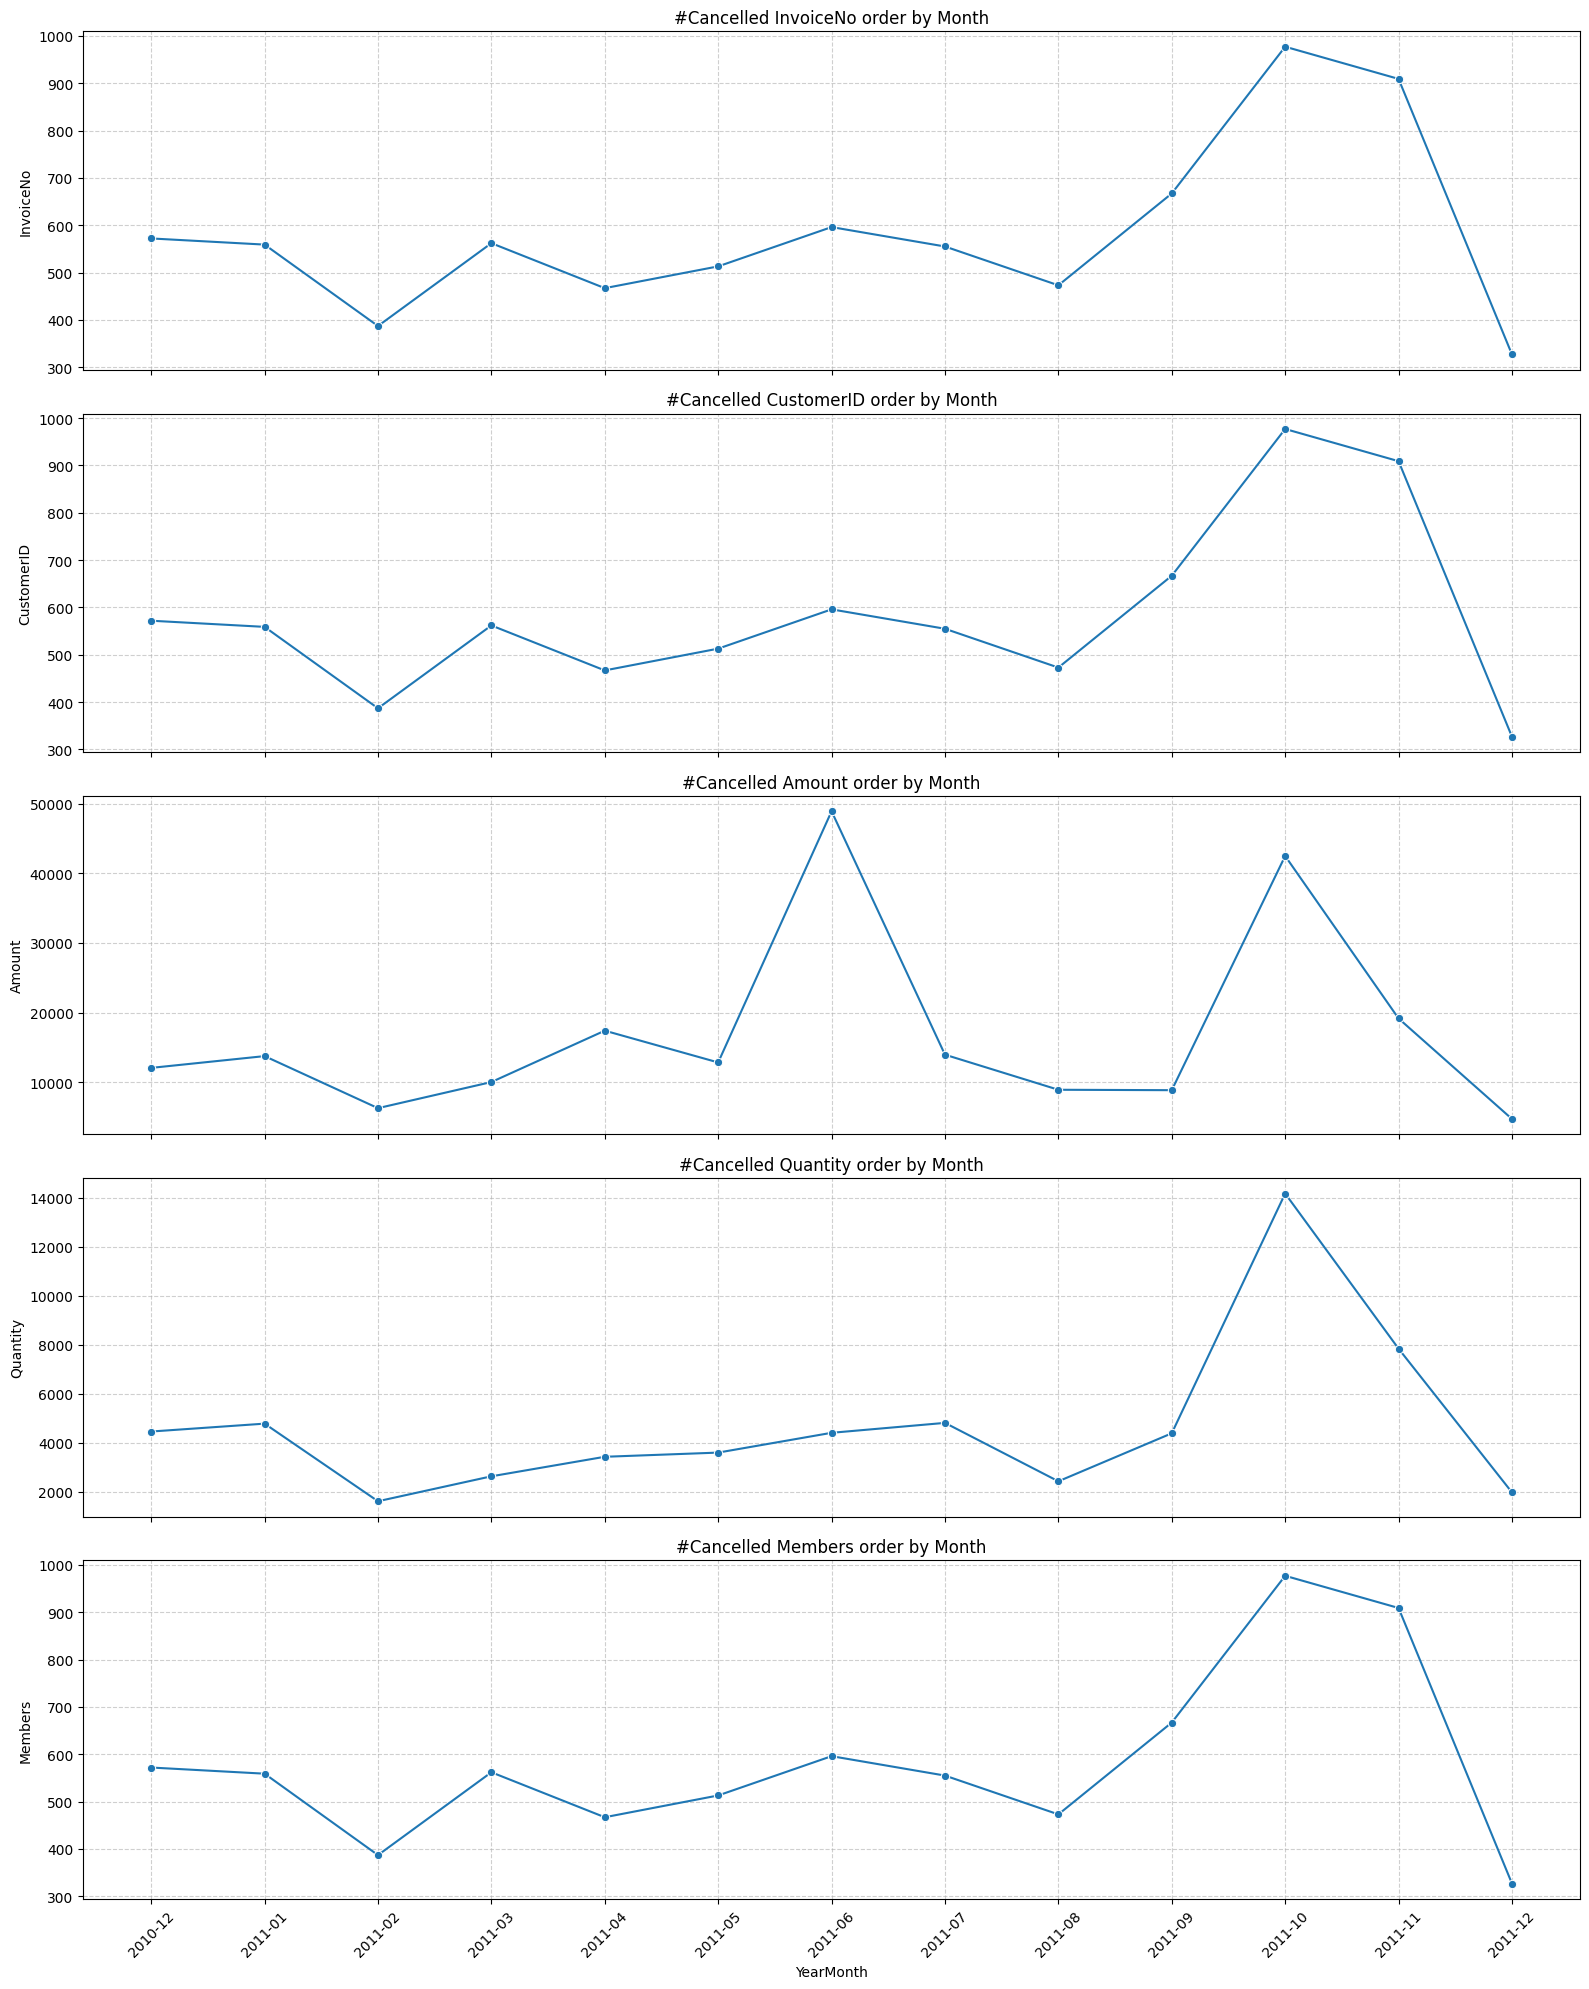

In [23]:
# Visualization
df_cancel['YearMonth'] = df_cancel['Year'].astype(str) + "-" + df_cancel['Month'].astype(str).str.zfill(2)
df_cancel.drop(['Year','Month'], axis =1, inplace=True)

fig, axes = plt.subplots(5, 1, figsize=(16,20), sharex=True)
metrics = ['InvoiceNo','CustomerID','Amount','Quantity','Members']

for ax, metric in zip(axes, metrics):
    sns.lineplot(data=df_cancel, x='YearMonth', y=metric, marker="o", ax=ax)
    ax.set_title(f"#Cancelled {metric} order by Month")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interpretation:
# -. On January and December 2011, there are some high-value cancelled order (small in invoiceNo, but huge in amount)

In [24]:
# Cancelled by Member or non Member
X[X['Success']==0].groupby('Members')[['InvoiceNo','CustomerID']].count()

# Interpretation: most of the cancelled order come from member.

,InvoiceNo,CustomerID
Members,,
1,7564,7564


In [25]:
## Identify high-value customers on cancelled order

customer_cancel = X[X['InvoiceNo'].str.contains('C', na=False)].groupby('CustomerID').agg({
    'Amount': ['sum', 'mean', 'count'],
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'StockCode': 'nunique'
}).round(2)

# Flatten column names
customer_cancel.columns = ['Total_Spent', 'Avg_Basket_Size', 'Total_Transactions', 
                           'Unique_Invoices', 'Total_Items', 'Unique_Products']

# Sort by total spent
customer_cancel.sort_values('Total_Spent', ascending=True)

# Insight: CRM teams can check the cause of cancelled high-value order based on CustomerID

,Total_Spent,Avg_Basket_Size,Total_Transactions,Unique_Invoices,Total_Items,Unique_Products
CustomerID,,,,,,
15098.0,-39267.00,-19633.50,2,2,-61,2
12744.0,-12158.90,-1736.99,7,3,-7,1
12536.0,-8495.01,-707.92,12,2,-151,10
14607.0,-5228.40,-186.73,28,3,-3768,27
15502.0,-4843.47,-124.19,39,11,-413,26
...,...,...,...,...,...,...
17164.0,-0.95,-0.95,1,1,-1,1
12421.0,-0.77,-0.77,1,1,-1,1
16566.0,-0.65,-0.65,1,1,-1,1


In [26]:
# Sort by total spent
customer_cancel.sort_values('Total_Items', ascending=True)

# Insight: CRM teams can check the cause of cancelled high-value order based on CustomerID

,Total_Spent,Avg_Basket_Size,Total_Transactions,Unique_Invoices,Total_Items,Unique_Products
CustomerID,,,,,,
14607.0,-5228.40,-186.73,28,3,-3768,27
15482.0,-4486.24,-154.70,29,4,-2022,24
16938.0,-833.25,-833.25,1,1,-1515,1
18133.0,-216.00,-216.00,1,1,-1350,1
14533.0,-137.10,-45.70,3,2,-1242,3
...,...,...,...,...,...,...
12505.0,-4.50,-4.50,1,1,-1,1
18158.0,-1.65,-1.65,1,1,-1,1
18164.0,-4.95,-4.95,1,1,-1,1


In [27]:
# Since we'll not use cancel order for further analysis, we can drop all cancelled transaction
X = X[~X['InvoiceNo'].str.startswith('C')]
X.drop('Success', axis=1, inplace=True)

### Gift Transactions

defines as order which has value in Quantity, but equals to zero in UnitPrice

In [28]:
# Check the gift transaction order vs. all
print(f"# Gift Items: {sum(X[X['Gift']==1].Quantity)}")
print(f"%Gift: {(sum(X[X['Gift']==1].Quantity)/sum(X.Quantity))*100:.2f}%")


# Gift Items: 129
%Gift: 0.00%


In [29]:
# Gift order by Country
X[X['Gift']==1].groupby('Country')[['InvoiceNo','CustomerID']].count().sort_values(by='InvoiceNo', ascending=False)

,InvoiceNo,CustomerID
Country,,
United Kingdom,18,18
Germany,2,2
France,1,1
Australia,1,1
Norway,1,1
RSA,1,1
Spain,1,1
Switzerland,1,1


In [30]:
# Gift order by Item
X[X['Gift']==1].groupby('StockCode')[['Quantity','Amount']].sum().sort_values(by='Quantity', ascending=False).head()

# There are two types of gift transactions:
# -. Quantity positive
# -. Quantity negative

# Why do they have two types of gift transactions??

,Quantity,Amount
StockCode,,
22062,36,0.0
84535B,16,0.0
22385,12,0.0
22065,12,0.0
22960,11,0.0


In [31]:
# Breakdown per Month
df_gift = X[X['Gift']==1].groupby(['Year','Month']).agg({
                'InvoiceNo':'count',
                'CustomerID':'count',
                'Amount':'sum',
                'Quantity':'sum',
                'Members':'sum',
                'Gift':'sum'
            }).reset_index()

df_gift['Amount'] = df_gift['Amount'].abs()
df_gift['Quantity'] = df_gift['Quantity'].abs()

df_gift

,Year,Month,InvoiceNo,CustomerID,Amount,Quantity,Members,Gift
0,2010,12,2,2,0.0,5,2,2
1,2011,1,1,1,0.0,1,1,1
2,2011,2,1,1,0.0,16,1,1
3,2011,3,2,2,0.0,41,2,2
4,2011,4,2,2,0.0,3,2,2
5,2011,5,1,1,0.0,4,1,1
6,2011,7,2,2,0.0,12,2,2
7,2011,8,1,1,0.0,1,1,1
8,2011,9,1,1,0.0,1,1,1
9,2011,10,3,3,0.0,8,3,3


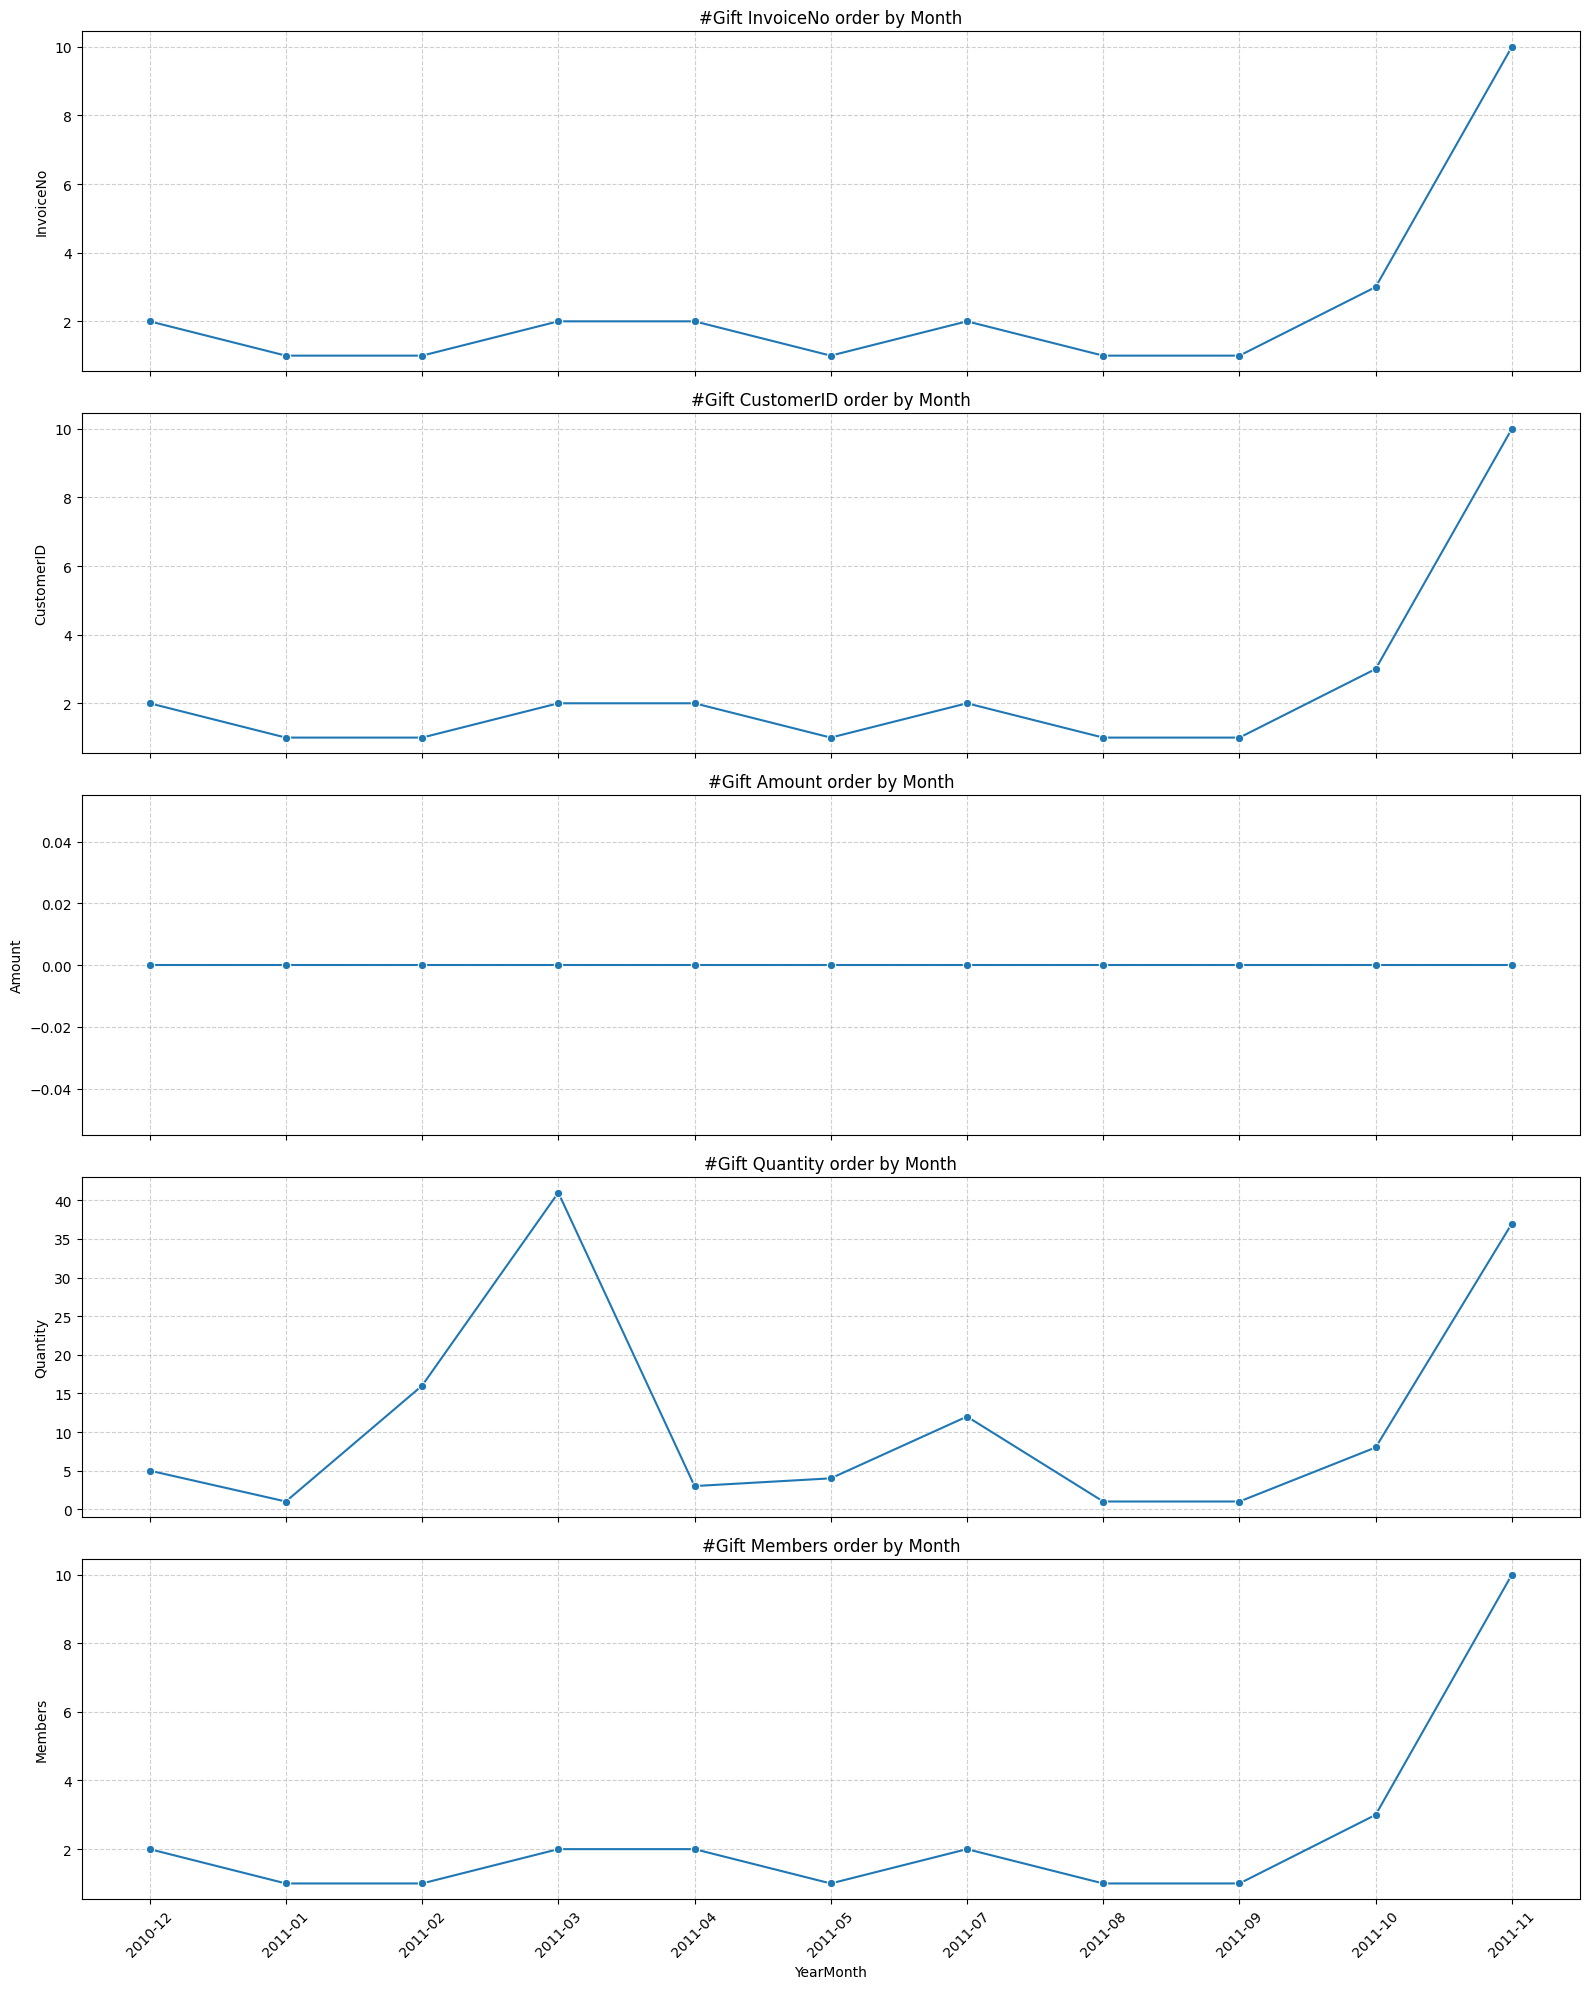

In [32]:
# Breakdown per Month
df_gift['YearMonth'] = df_gift['Year'].astype(str) + "-" + df_gift['Month'].astype(str).str.zfill(2)
df_gift.drop(['Year','Month'], axis =1, inplace=True)

fig, axes = plt.subplots(5, 1, figsize=(16,20), sharex=True)
metrics = ['InvoiceNo','CustomerID','Amount','Quantity','Members']

for ax, metric in zip(axes, metrics):
    sns.lineplot(data=df_gift, x='YearMonth', y=metric, marker="o", ax=ax)
    ax.set_title(f"#Gift {metric} order by Month")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
# Cancelled by Member or non Member
X[X['Gift']==1].groupby('Members')[['InvoiceNo','CustomerID']].count()

,InvoiceNo,CustomerID
Members,,
1,26,26


In [34]:
# We'll add identifier "G" in front of the StockCode, so we know it's a free product
X['StockCode'] = np.where(X['Gift'] == 1, str("G"+X['StockCode']), X['StockCode'])
X.drop('Gift', axis=1, inplace=True)

### Analyse Product Description

In [35]:
# Check if the description is NAN
X[X['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Members,Year,Month,Day,Hour,Min


In [36]:
# Check the product's characteristics to understand who are the customers

descriptions = X['Description'].unique()

def clean_text(text):
    """Clean and normalize product descriptions"""
    text = str(text).upper()
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

clean_descriptions = [clean_text(i) for i in descriptions]
all_desc = ' '.join(clean_descriptions)
all_desc


'WHITE HANGING HEART T LIGHT HOLDER WHITE METAL LANTERN CREAM CUPID HEARTS COAT HANGER KNITTED UNION FLAG HOT WATER BOTTLE RED WOOLLY HOTTIE WHITE HEART SET BABUSHKA NESTING BOXES GLASS STAR FROSTED T LIGHT HOLDER HAND WARMER UNION JACK HAND WARMER RED POLKA DOT ASSORTED COLOUR BIRD ORNAMENT POPPY S PLAYHOUSE BEDROOM POPPY S PLAYHOUSE KITCHEN FELTCRAFT PRINCESS CHARLOTTE DOLL IVORY KNITTED MUG COSY BOX OF ASSORTED COLOUR TEASPOONS BOX OF VINTAGE JIGSAW BLOCKS BOX OF VINTAGE ALPHABET BLOCKS HOME BUILDING BLOCK WORD LOVE BUILDING BLOCK WORD RECIPE BOX WITH METAL HEART DOORMAT NEW ENGLAND JAM MAKING SET WITH JARS RED COAT RACK PARIS FASHION YELLOW COAT RACK PARIS FASHION BLUE COAT RACK PARIS FASHION BATH BUILDING BLOCK WORD ALARM CLOCK BAKELIKE PINK ALARM CLOCK BAKELIKE RED ALARM CLOCK BAKELIKE GREEN PANDA AND BUNNIES STICKER SHEET STARS GIFT TAPE INFLATABLE POLITICAL GLOBE VINTAGE HEADS AND TAILS CARD GAME SET RED RETROSPOT TEA TOWELS ROUND SNACK BOXES SET OF WOODLAND SPACEBOY LUNCH BOX 

c:\Users\ignasius.dwi\Downloads\Github\[DONE]data-mining_online-retail\.venv\lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
c:\Users\ignasius.dwi\Downloads\Github\[DONE]data-mining_online-retail\.venv\lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

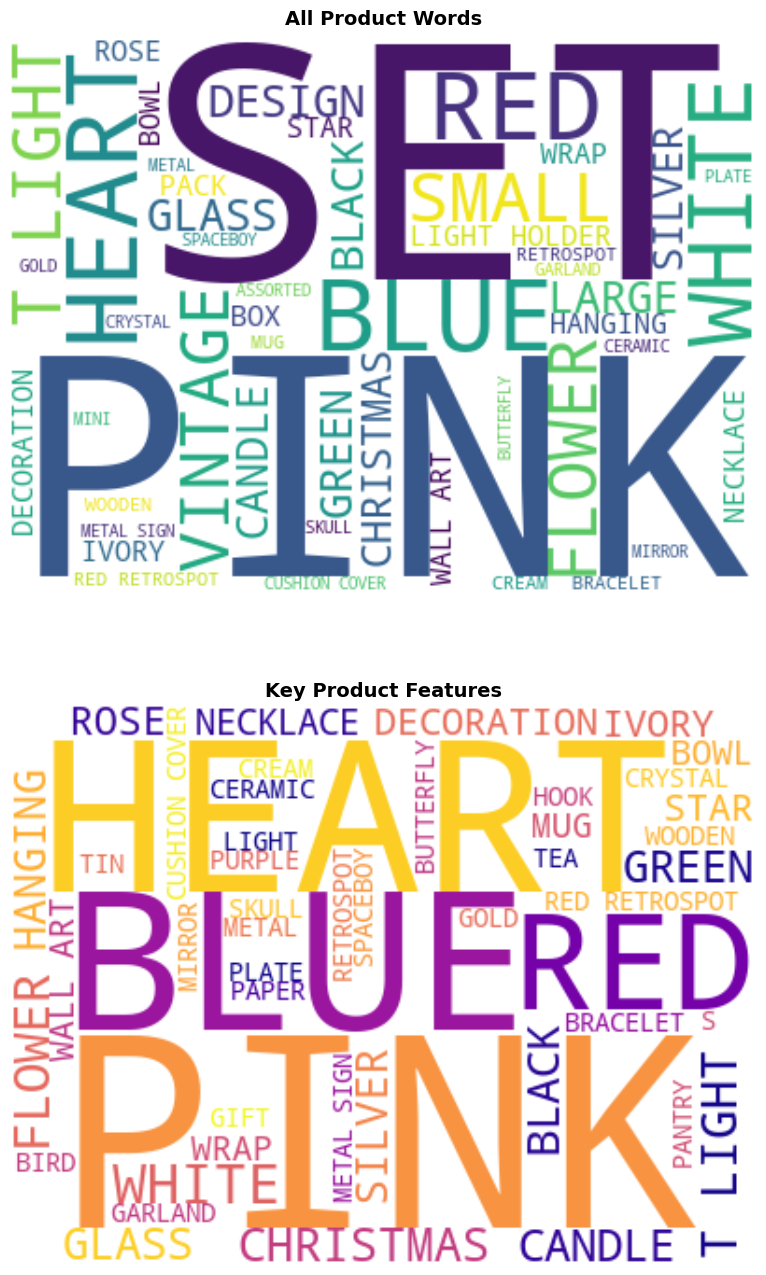

In [37]:
# Self-define of retail stopwords
retail_stopwords = {
    'SET', 'PACK', 'VINTAGE', 'DESIGN', 'STYLE', 'HOLDER', 'WITH', 'AND', 'THE', 'OF', 
    'FOR', 'IN', 'ON', 'PIECE', 'BOX', 'BAG', 'SMALL', 'LARGE', 'NEW', 'OLD', 'BIG',
    'LITTLE', 'MINI', 'JUMBO', 'ASSORTED', 'MIXED', 'SINGLE', 'DOUBLE', 'TRIPLE'
}

# Word cloud
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 16))

wordcloud1 = WordCloud(width=400, height=300, background_color='white', 
                       max_words=50, colormap='viridis').generate(all_desc)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.set_title('All Product Words', fontsize=14, fontweight='bold')
ax1.axis('off')

wordcloud2 = WordCloud(width=400, height=300, background_color='white', 
                       max_words=50, colormap='plasma', 
                       stopwords=retail_stopwords).generate(all_desc)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.set_title('Key Product Features', fontsize=14, fontweight='bold')
ax2.axis('off')

Text(0.5, 1.0, 'Top 15 Product Keywords')

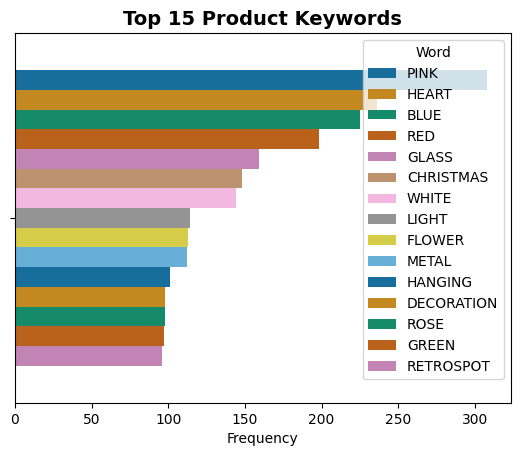

In [38]:
words = [word for word in all_desc.split() if word not in retail_stopwords and len(word) > 2]
word_freq = Counter(words).most_common(15)
words_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

sns.barplot(data=words_df, x='Frequency', hue='Word', palette='colorblind').set_title('Top 15 Product Keywords', fontsize=14, fontweight='bold')


In [39]:
# Since column Description is not consistent sometimes, and its values reflects by StockCode, we can drop the column.
X.drop('Description', axis=1, inplace=True)
X

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Members,Year,Month,Day,Hour,Min
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,1,2010,12,1,8,26
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,2010,12,1,8,26
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,1,2010,12,1,8,26
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,2010,12,1,8,26
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,2010,12,1,8,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,1,2011,12,9,12,50
541905,581587,22899,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,1,2011,12,9,12,50
541906,581587,23254,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,1,2011,12,9,12,50
541907,581587,23255,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,1,2011,12,9,12,50


### Regular Order

#### Top Items

In [40]:
df_item = X.groupby('StockCode')[['Quantity','Amount']].sum()

In [41]:
# Top Items by Qty
df_item.sort_values('Quantity', ascending=False)

,Quantity,Amount
StockCode,,
84077,27432,7586.64
84879,25594,42063.46
85099B,24292,46824.67
22197,22362,17577.70
85123A,21429,58725.15
...,...,...
90181A,1,8.95
90183C,1,2.95
47503J,1,7.95


In [42]:
# Top Items by Amount
df_item.sort_values('Amount', ascending=False)

,Quantity,Amount
StockCode,,
22423,7669,89823.850
POST,2942,64291.710
85123A,21429,58725.150
47566,11433,52525.250
85099B,24292,46824.670
...,...,...
21785,1,0.850
90084,1,0.850
21268,2,0.840


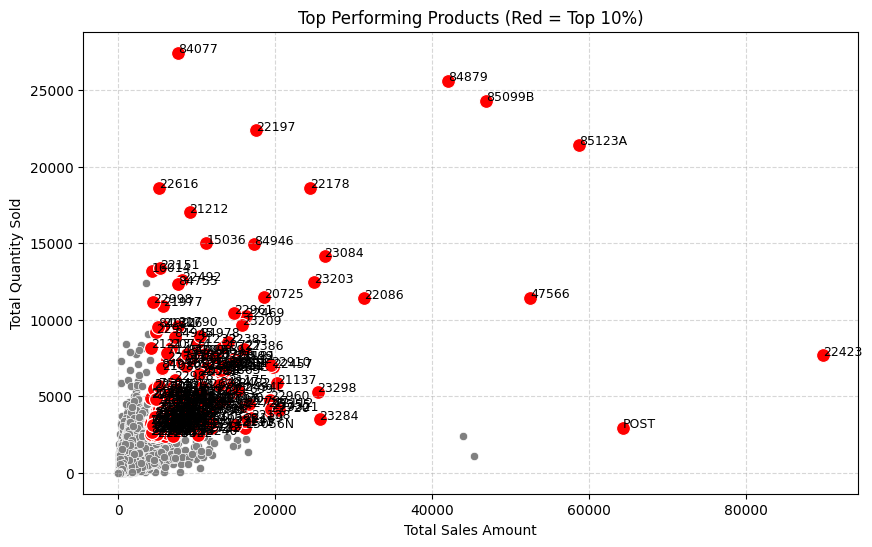

In [43]:
df_item = df_item.reset_index()

# Define thresholds (e.g., top 10% by Amount and Quantity)
amount_thresh = df_item['Amount'].quantile(0.9)
quantity_thresh = df_item['Quantity'].quantile(0.9)

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_item, x='Amount', y='Quantity', color='gray')

# Highlight top performers
top_perf = df_item[(df_item['Amount'] >= amount_thresh) & (df_item['Quantity'] >= quantity_thresh)]
sns.scatterplot(data=top_perf, x='Amount', y='Quantity', color='red', s=100)

# Annotate top performers
for i, row in top_perf.iterrows():
    plt.text(row['Amount'], row['Quantity'], row['StockCode'], fontsize=9)

plt.title("Top Performing Products (Red = Top 10%)")
plt.xlabel("Total Sales Amount")
plt.ylabel("Total Quantity Sold")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#### Top Customers

In [44]:
df_cust = X.groupby('CustomerID')[['Quantity','Amount']].sum()

In [45]:
# Top Customers by Quantity
df_cust.sort_values('Quantity', ascending=False)

,Quantity,Amount
CustomerID,,
13777.0,12897,25977.16
14607.0,11766,16569.50
17306.0,11491,8631.31
15159.0,11441,18641.01
15856.0,11005,16387.57
...,...,...
16257.0,2,46.95
15510.0,2,250.00
16742.0,1,464.90


In [46]:
# Top Customers by Amount
df_cust.sort_values('Amount', ascending=False)

,Quantity,Amount
CustomerID,,
15098.0,121,39916.50
17389.0,7612,31833.68
13777.0,12897,25977.16
12744.0,5241,21279.29
17675.0,8360,20374.28
...,...,...
16878.0,12,13.30
17956.0,1,12.75
16454.0,3,6.90


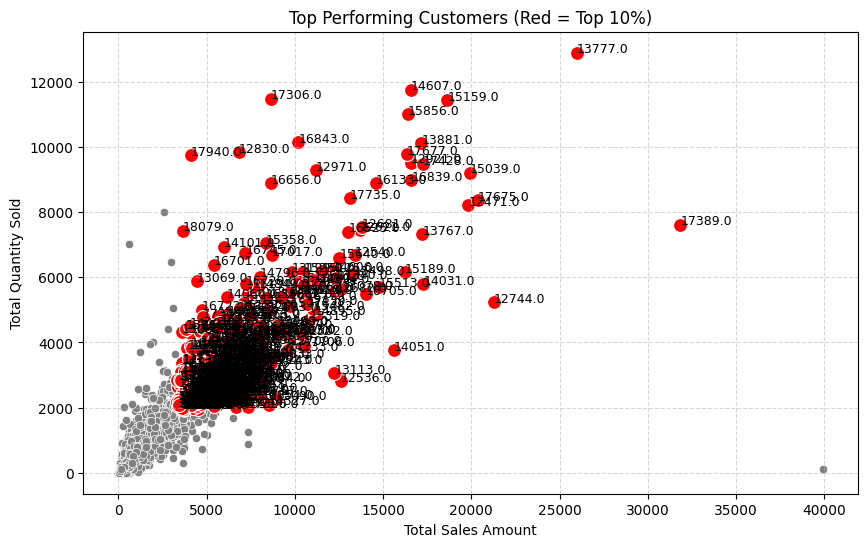

In [47]:
quantil = 0.9
df_cust = df_cust.reset_index()

# Define thresholds (e.g., top 10% by Amount and Quantity)
amount_thresh = df_cust['Amount'].quantile(quantil)
quantity_thresh = df_cust['Quantity'].quantile(quantil)

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_cust, x='Amount', y='Quantity', color='gray')

# Highlight top performers
top_perf = df_cust[(df_cust['Amount'] >= amount_thresh) & (df_cust['Quantity'] >= quantity_thresh)]
sns.scatterplot(data=top_perf, x='Amount', y='Quantity', color='red', s=100)

# Annotate top performers
for i, row in top_perf.iterrows():
    plt.text(row['Amount'], row['Quantity'], row['CustomerID'], fontsize=9)

plt.title("Top Performing Customers (Red = Top 10%)")
plt.xlabel("Total Sales Amount")
plt.ylabel("Total Quantity Sold")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Countries

In [48]:
df_country = X.groupby('Country').agg({
                'InvoiceNo':'count',
                'CustomerID':'count',
                'Amount':'sum',
                'Quantity':'sum',
                'Members':'sum',
            }).reset_index()

# Number of Transaction by Country
df_country.sort_values(by='InvoiceNo', ascending=False).head(10)

,Country,InvoiceNo,CustomerID,Amount,Quantity,Members
33,United Kingdom,317697,317697,5087692.193,2993338,317697
13,Germany,8448,8448,201481.470,107657,8448
12,France,7903,7903,172499.680,92112,7903
28,Spain,2394,2394,48506.750,23037,2394
3,Belgium,1820,1820,36568.420,20033,1820
24,Portugal,1365,1365,30648.300,13987,1365
30,Switzerland,944,944,24483.810,11326,944
5,Channel Islands,734,734,17233.730,7756,734
11,Finland,631,631,20835.690,9847,631
17,Italy,620,620,14532.370,6635,620


In [49]:
# Number of Customer by Country
df_country.sort_values(by='CustomerID', ascending=False).head(10)

,Country,InvoiceNo,CustomerID,Amount,Quantity,Members
33,United Kingdom,317697,317697,5087692.193,2993338,317697
13,Germany,8448,8448,201481.470,107657,8448
12,France,7903,7903,172499.680,92112,7903
28,Spain,2394,2394,48506.750,23037,2394
3,Belgium,1820,1820,36568.420,20033,1820
24,Portugal,1365,1365,30648.300,13987,1365
30,Switzerland,944,944,24483.810,11326,944
5,Channel Islands,734,734,17233.730,7756,734
11,Finland,631,631,20835.690,9847,631
17,Italy,620,620,14532.370,6635,620


In [50]:
# Amount by Country
df_country.sort_values(by='Amount', ascending=False).head(10)

,Country,InvoiceNo,CustomerID,Amount,Quantity,Members
33,United Kingdom,317697,317697,5087692.193,2993338,317697
13,Germany,8448,8448,201481.470,107657,8448
12,France,7903,7903,172499.680,92112,7903
28,Spain,2394,2394,48506.750,23037,2394
3,Belgium,1820,1820,36568.420,20033,1820
24,Portugal,1365,1365,30648.300,13987,1365
30,Switzerland,944,944,24483.810,11326,944
27,Singapore,222,222,21279.290,5241,222
11,Finland,631,631,20835.690,9847,631
5,Channel Islands,734,734,17233.730,7756,734


#### Operational Matrix: Month, Day, Hour

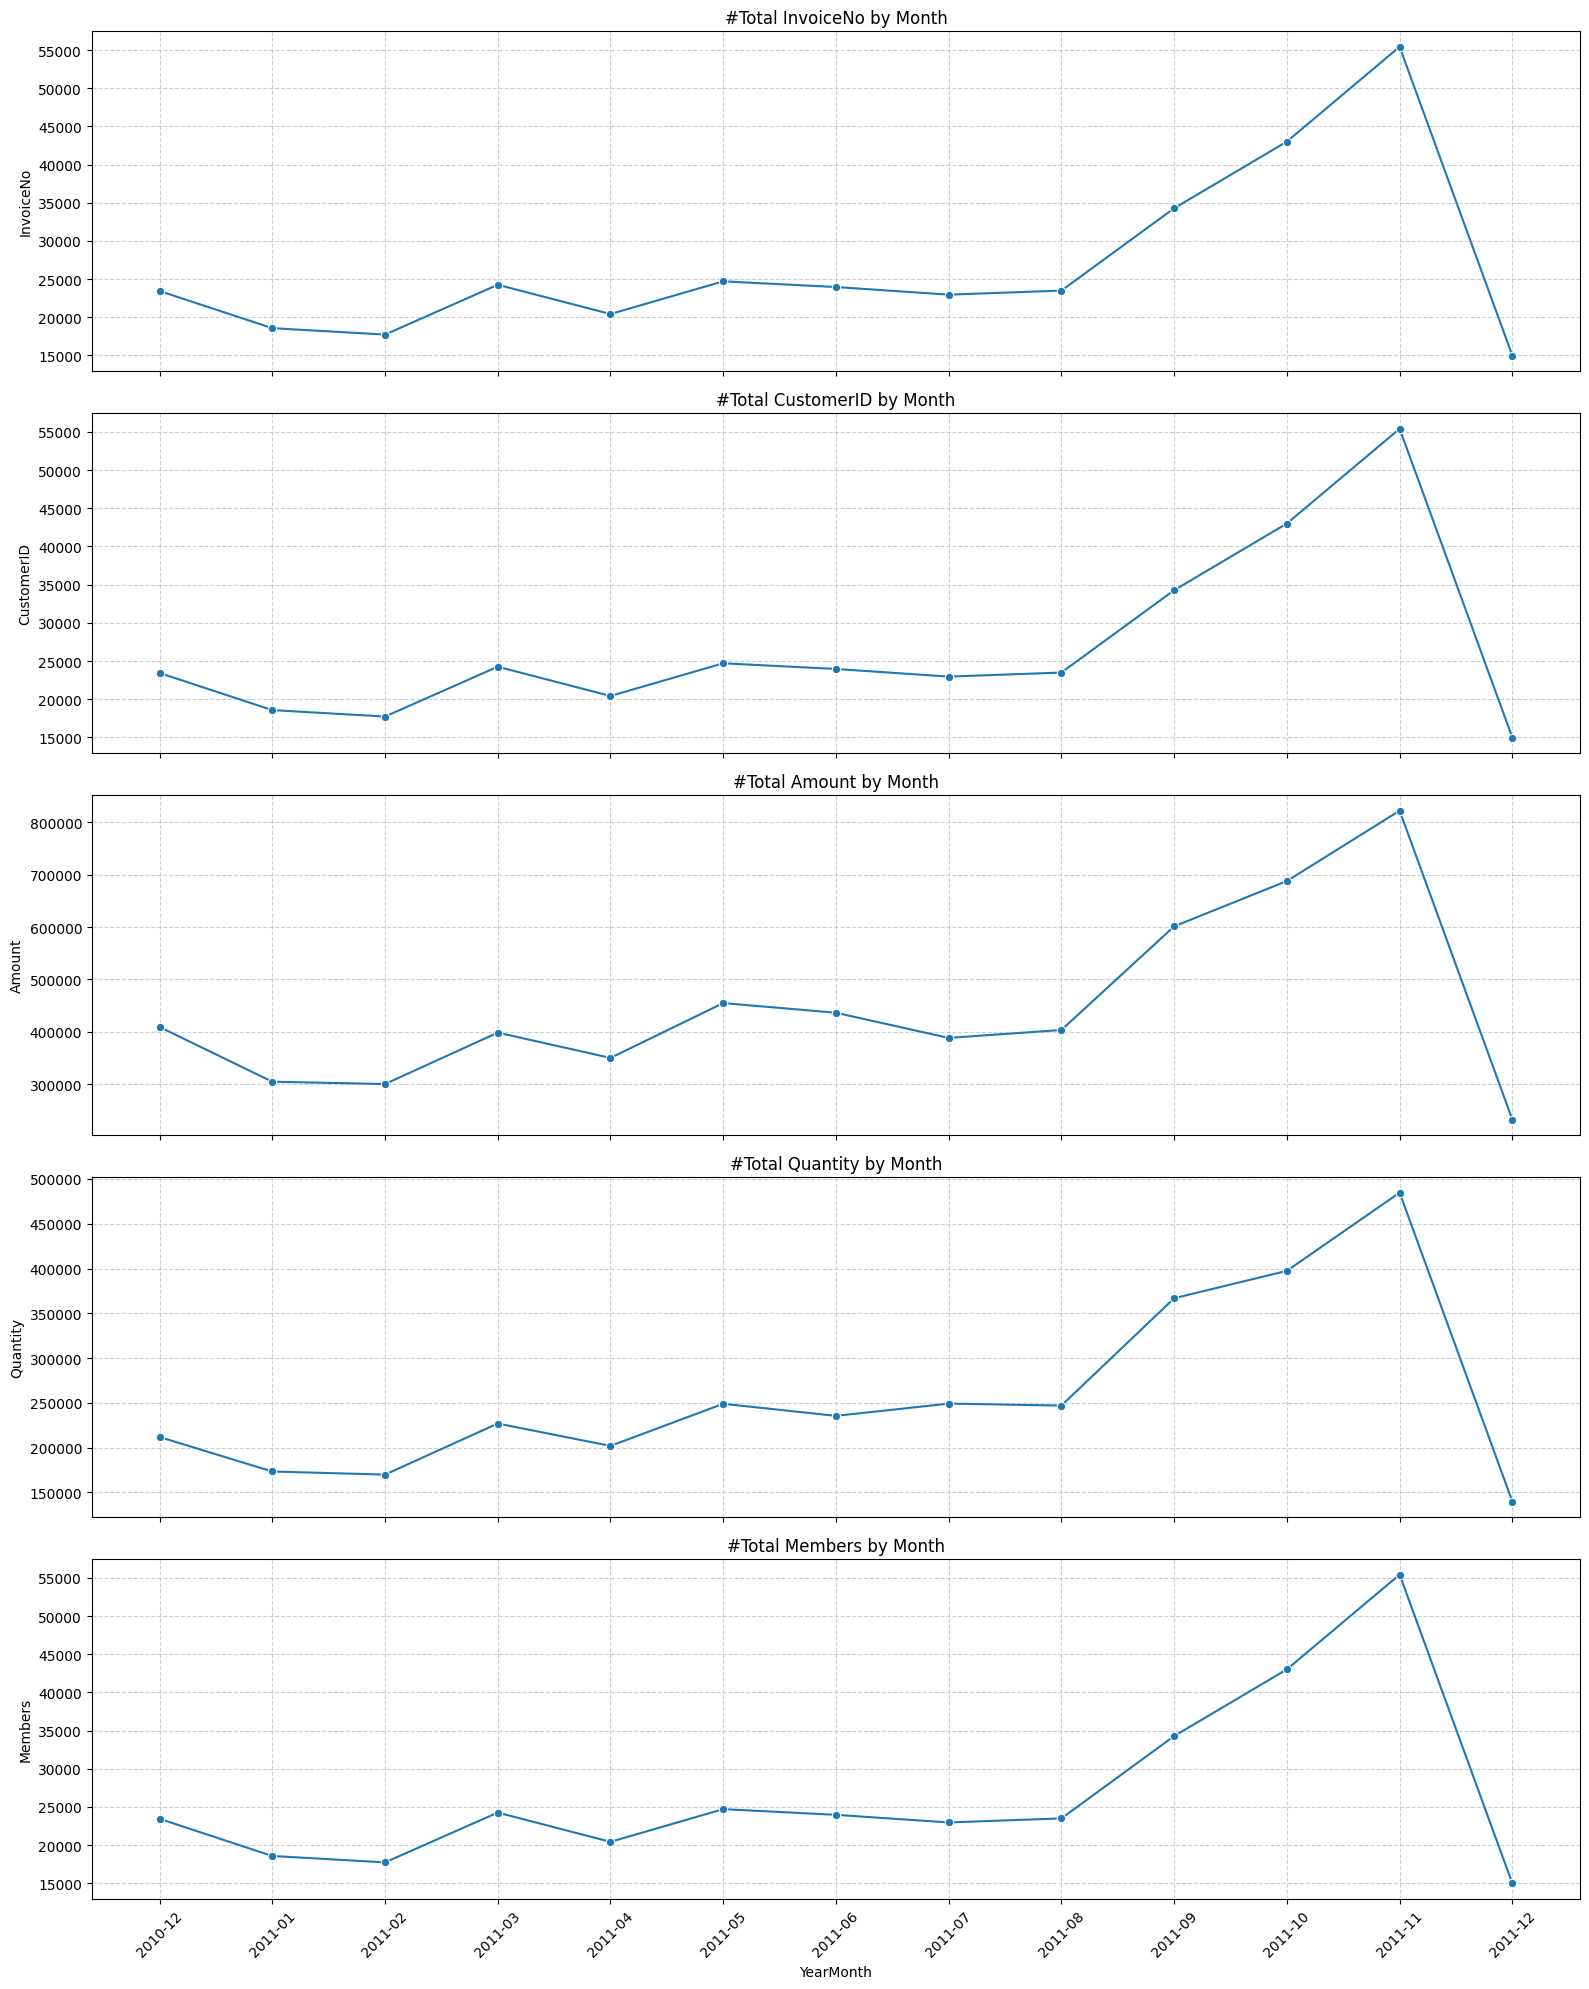

In [51]:
# Breakdown per Month
df = X.groupby(['Year','Month']).agg({
                'InvoiceNo':'count',
                'CustomerID':'count',
                'Amount':'sum',
                'Quantity':'sum',
                'Members':'sum'
            }).reset_index()

# Visualization
df['YearMonth'] = df['Year'].astype(str) + "-" + df['Month'].astype(str).str.zfill(2)
df.drop(['Year','Month'], axis =1, inplace=True)

fig, axes = plt.subplots(5, 1, figsize=(16,20), sharex=True)
metrics = ['InvoiceNo','CustomerID','Amount','Quantity','Members']

for ax, metric in zip(axes, metrics):
    sns.lineplot(data=df, x='YearMonth', y=metric, marker="o", ax=ax)
    ax.set_title(f"#Total {metric} by Month")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# Peak Day by InvoiceNo
df_day = X.groupby('Day').agg({
                'InvoiceNo':'count',
                'CustomerID':'count',
                'Amount':'sum',
                'Quantity':'sum',
                'Members':'sum'
            }).reset_index()

df_day.sort_values(by='InvoiceNo', ascending=False).head(10)

,Day,InvoiceNo,CustomerID,Amount,Quantity,Members
5,6,16029,16029,235370.33,141304,16029
7,8,14097,14097,235379.75,139266,14097
4,5,13880,13880,225306.16,138051,13880
6,7,13723,13723,221332.99,132031,13723
19,20,13208,13208,208064.10,119399,13208
3,4,13145,13145,202126.20,112262,13145
12,13,12959,12959,195118.34,112687,12959
16,17,12787,12787,212875.48,125517,12787
13,14,12136,12136,214866.59,120117,12136
22,23,11967,11967,178091.00,103300,11967


In [53]:
# Peak Hours
df_hours = X.groupby('Hour').agg({
                'InvoiceNo':'count',
                'CustomerID':'count',
                'Amount':'sum',
                'Quantity':'sum',
                'Members':'sum'
            }).reset_index()

df_hours.sort_values(by='Hour', ascending=False).head(10)

,Hour,InvoiceNo,CustomerID,Amount,Quantity,Members
14,20,752,752,5817.570,4671,752
13,19,2663,2663,31304.620,17008,2663
12,18,2619,2619,46602.480,25637,2619
11,17,10523,10523,154024.661,92545,10523
10,16,22229,22229,324231.410,185150,22229
9,15,39207,39207,670467.710,373443,39207
8,14,46357,46357,704433.081,405530,46357
7,13,56314,56314,824014.860,481971,56314
6,12,64306,64306,958682.060,568628,64306
5,11,43174,43174,673194.540,392855,43174


In [54]:
# Reduce the columns
X.drop(['Year','Month','Day','Hour', 'Min'], axis=1, inplace=True)

## Apriori

Since the transactions data is incredibly massive, we'll focus on top 1,000 most frequent items.

In [55]:
# Prepare the dataset
transactions = X.groupby('InvoiceNo')['StockCode'].apply(set).tolist()
total_transactions = len(transactions)

In [56]:
item_counts = Counter()
for transaction in transactions:
    item_counts.update(transaction)
        
print(f"Unique items: {len(item_counts):,}")

# Top 1000 items
top_items = [item for item, count in item_counts.most_common(1000)]
print(f"Taking top {len(top_items)} items (out of {len(item_counts)} total)")
filtered_transactions = []
for transaction in transactions:
    filtered_transaction = transaction.intersection(set(top_items))
    if len(filtered_transaction) >= 2:  # Only keep transactions with 2+ items
        filtered_transactions.append(filtered_transaction)
print(f"Filtered transactions: {len(filtered_transactions):,}")

Unique items: 3,630
Taking top 1000 items (out of 3630 total)
Filtered transactions: 14,992


In [57]:
min_support = 0.01

total_transactions = len(transactions)
min_support_count = int(min_support * total_transactions)
        
print(f"Minimum support count: {min_support_count}")

        
# Frequent 1-itemsets
frequent_items = {item: count for item, count in item_counts.items() if count >= min_support_count}
print(f"Frequent 1-itemsets: {len(frequent_items)}")
        
# Generate frequent 2-itemsets
frequent_item_list = list(frequent_items.keys())
pair_counts = Counter()
        
for transaction in transactions:
    # Only consider items that are frequent
    frequent_in_transaction = [item for item in transaction if item in frequent_items]
            
    if len(frequent_in_transaction) >= 2:
        pairs = list(combinations(sorted(frequent_in_transaction), 2))
        pair_counts.update(pairs)
        
# Filter frequent pairs
frequent_pairs = {pair: count for pair, count in pair_counts.items() if count >= min_support_count}
print(f"Frequent 2-itemsets: {len(frequent_pairs)}")

Minimum support count: 164
Frequent 1-itemsets: 623
Frequent 2-itemsets: 321


In [58]:
itemsets_data = []

# Add 1-itemsets
for item, count in frequent_items.items():
    itemsets_data.append({
        'itemsets': frozenset([item]),
        'support': count / total_transactions,
        'length': 1
    })

# Add 2-itemsets
for pair, count in frequent_pairs.items():
    itemsets_data.append({
        'itemsets': frozenset(pair),
        'support': count / total_transactions,
        'length': 2
    })

frequent_itemsets_df = pd.DataFrame(itemsets_data)

# Create association rules
rules_data = []

for (item1, item2), count in frequent_pairs.items():
    support_pair = count / total_transactions
    support_item1 = frequent_items[item1] / total_transactions
    support_item2 = frequent_items[item2] / total_transactions
    
    # Rule: item1 -> item2
    confidence_1_2 = support_pair / support_item1
    lift_1_2 = confidence_1_2 / support_item2
    conviction_1_2 = (1 - support_item2) / (1 - confidence_1_2) if confidence_1_2 < 1 else float('inf')
    
    rules_data.append({
        'antecedents': frozenset([item1]),
        'consequents': frozenset([item2]),
        'antecedent_support': support_item1,
        'consequent_support': support_item2,
        'support': support_pair,
        'confidence': confidence_1_2,
        'lift': lift_1_2,
        'conviction': conviction_1_2
    })
    
    # Rule: item2 -> item1
    confidence_2_1 = support_pair / support_item2
    lift_2_1 = confidence_2_1 / support_item1
    conviction_2_1 = (1 - support_item1) / (1 - confidence_2_1) if confidence_2_1 < 1 else float('inf')
    
    rules_data.append({
        'antecedents': frozenset([item2]),
        'consequents': frozenset([item1]),
        'antecedent_support': support_item2,
        'consequent_support': support_item1,
        'support': support_pair,
        'confidence': confidence_2_1,
        'lift': lift_2_1,
        'conviction': conviction_2_1
    })

association_rules_df = pd.DataFrame(rules_data).sort_values('lift', ascending=False)

print(f"Generated {len(association_rules_df)} association rules")

Generated 642 association rules


In [59]:
# Top rules
association_rules_df

,antecedents,consequents,antecedent_support,consequent_support,support,confidence,lift,conviction
599,(23175),(23174),0.013335,0.012850,0.010001,0.750000,58.365566,3.948600
598,(23174),(23175),0.012850,0.013335,0.010001,0.778302,58.365566,4.450489
597,(23171),(23170),0.012183,0.015093,0.010183,0.835821,55.379009,5.998981
596,(23170),(23171),0.015093,0.012183,0.010183,0.674699,55.379009,3.036622
317,(21094),(21086),0.015941,0.014608,0.012244,0.768061,52.578704,4.248494
...,...,...,...,...,...,...,...,...
420,(22720),(85123A),0.061704,0.108862,0.010304,0.166994,1.534003,1.069786
262,(85099B),(85123A),0.083647,0.108862,0.013214,0.157971,1.451117,1.058323
263,(85123A),(85099B),0.108862,0.083647,0.013214,0.121381,1.451117,1.042947
199,(85123A),(22423),0.108862,0.090496,0.012305,0.113029,1.248996,1.025405


## RFM

RFM clustering is a way to segment customers based on their purchase behavior. There are 3 parameters to use:
- **Recency**: when was the last time customer purchased vs. today/reference date?
- **Frequency**: within certain period (e.g. 1 year), how many purchase did customer do?
- **Monetary**: within certain period (e.g. 1 year), how much money did customer spend?

In [60]:
# Since the dataset ends in 09/12/2011, we assume the reference_date would be 31/12/2011
reference_date = np.datetime64("2011-12-31")

# Prepare the dataset
rfm = X.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
            'InvoiceNo': 'nunique',  # Frequency within one year period
            'Amount': 'sum'  # Monetary within one year period
        }).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm

,CustomerID,Recency,Frequency,Monetary
0,12347.0,23,7,4310.00
1,12348.0,96,4,1797.24
2,12350.0,331,1,334.40
3,12352.0,57,8,2506.04
4,12353.0,225,1,89.00
...,...,...,...,...
4198,18280.0,298,1,180.60
4199,18281.0,201,1,80.82
4200,18282.0,28,2,178.05
4201,18283.0,24,16,2094.88


In [61]:
# Calculate RFM scores (1-5 scale, 5 being the best)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12347.0,23,7,4310.00,5,5,5
1,12348.0,96,4,1797.24,2,4,4
2,12350.0,331,1,334.40,1,1,2
3,12352.0,57,8,2506.04,3,5,5
4,12353.0,225,1,89.00,1,1,1
...,...,...,...,...,...,...,...
4198,18280.0,298,1,180.60,1,2,1
4199,18281.0,201,1,80.82,1,2,1
4200,18282.0,28,2,178.05,5,3,1
4201,18283.0,24,16,2094.88,5,5,5


In [62]:
# There are some ways to create RFM Score. This score will be used to cluster the customers' segmentation.

# The 1st way is to concat all R_Score, F_Score, M_Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# The 2nd way is to calculate mean / weighted mean of R_Score, F_Score, M_Score
rfm['RFM_Overall'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).mean(axis=1)

# The 3rd way is to use PCA to combine all of them
pca = PCA(n_components=1)
rfm_pca_scores = pca.fit_transform(rfm[['R_Score','F_Score','M_Score']])
rfm['RFM_PCA'] = rfm_pca_scores[:, 0]  # Use the first principal component

rfm

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Overall,RFM_PCA
0,12347.0,23,7,4310.00,5,5,5,555,5.000000,3.447897
1,12348.0,96,4,1797.24,2,4,4,244,3.333333,0.702697
2,12350.0,331,1,334.40,1,1,2,112,1.333333,-2.855356
3,12352.0,57,8,2506.04,3,5,5,355,4.333333,2.429009
4,12353.0,225,1,89.00,1,1,1,111,1.000000,-3.457351
...,...,...,...,...,...,...,...,...,...,...
4198,18280.0,298,1,180.60,1,2,1,121,1.333333,-2.842478
4199,18281.0,201,1,80.82,1,2,1,121,1.333333,-2.842478
4200,18282.0,28,2,178.05,5,3,1,531,3.000000,-0.189831
4201,18283.0,24,16,2094.88,5,5,5,555,5.000000,3.447897


In [63]:
# Free define customer segmentation

def segment_customers(row):
    if row['RFM_Overall'] >= 4.5:
        return 'Champions'
    elif row['RFM_Overall'] >= 4:
        return 'Loyal Customers'
    elif row['RFM_Overall'] >= 3.5:
        return 'Potential Loyalists'
    elif row['RFM_Overall'] >= 3:
        return 'New Customers'
    elif row['RFM_Overall'] >= 2.5:
        return 'Promising'
    elif row['RFM_Overall'] >= 2:
        return 'Need Attention'
    else:
        return 'At Risk'
rfm['Segment'] = rfm.apply(segment_customers, axis=1)

In [64]:
# Distribution per segment
print(rfm['Segment'].value_counts())

Segment
At Risk                874
Need Attention         761
New Customers          660
Champions              631
Loyal Customers        592
Promising              357
Potential Loyalists    328
Name: count, dtype: int64


In [65]:
# Characteristics per segment
print(rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean())

                        Recency  Frequency     Monetary
Segment                                                
At Risk              244.528604   1.044622   226.525435
Champions             31.136292  11.846276  4507.266830
Loyal Customers       49.981419   5.417230  2021.807584
Need Attention       129.681997   1.453351   392.514049
New Customers         83.212121   2.739394   908.236182
Potential Loyalists   65.009146   3.878049  1331.070155
Promising            108.476190   2.008403   599.221739


## Calculate CLV

Steps:
- Calculate the LifespanDays = Last Purchase - First Purchase
- Calculate the PurchaseFrequency = UniqueInvoices / LifespanDays
- Define churn: A customer is churned if they haven’t purchased in the last 90 days before your reference date
- Use survival analysis to estimate the probability a customer is still active at each time point:
    - Fit Kaplan-Meier on churn events: non-parametric survival function
    - Estimate survival function 𝑆(𝑡) = P(customer is still active at time t).
    - Combine with expected spend per active period.
- Estimate Expected Active Time

This captures different churn risks across customers instead of assuming everyone lives longer by the same amount.

In [66]:
# Assume predictions month = 12
prediction_months = 12
churn_threshold = 90

# Customer metrics for CLV calculation
customer_data = X.groupby('CustomerID').agg(
    FirstPurchase=('InvoiceDate', 'min'),
    LastPurchase=('InvoiceDate', 'max'),
    TotalTransactions=('InvoiceDate', 'count'),
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    TotalRevenue=('Amount', 'sum'),
    AvgOrderValue=('Amount', 'mean')
).reset_index()

# Calculate customer lifespan in days
customer_data['LifespanDays'] = (customer_data['LastPurchase'] - customer_data['FirstPurchase']).dt.days
customer_data['LifespanDays'] = customer_data['LifespanDays'].replace(0, 1) 

# Define churned
customer_data['Churned'] = (customer_data['Recency'] > churn_threshold).astype(int)

customer_data = customer_data[['CustomerID','FirstPurchase','LastPurchase','LifespanDays','Churned','TotalRevenue','AvgOrderValue','Frequency']]

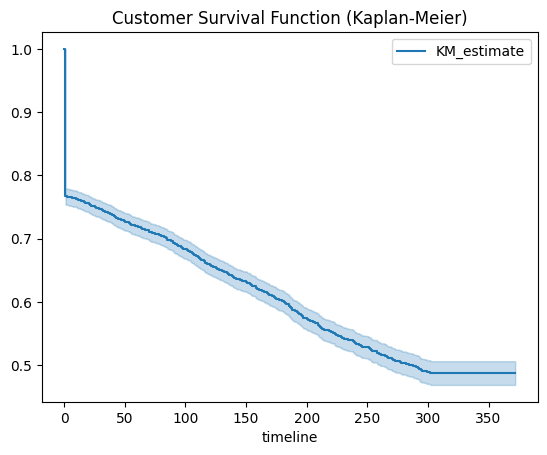

In [67]:
# Cox Proportional Hazards
kmf = KaplanMeierFitter()
kmf.fit(
    durations=customer_data['LifespanDays'],
    event_observed=customer_data['Churned']
)

kmf.plot_survival_function()
plt.title("Customer Survival Function (Kaplan-Meier)")
plt.show()

In [68]:
expected_time = kmf.median_survival_time_   # median lifetime


In [69]:
customer_data['ExpectedLifetime'] = restricted_mean_survival_time(kmf, t=365*2)  # up to 2 years
customer_data['CLV'] = (
    customer_data['AvgOrderValue'] *
    customer_data['Frequency'] *
    customer_data['ExpectedLifetime']
)

In [70]:
print(customer_data.nlargest(10, 'CLV'))

     CustomerID       FirstPurchase        LastPurchase  LifespanDays  \
1932    15098.0 2011-06-10 15:22:00 2011-06-10 15:33:00             1   
3562    17389.0 2011-01-12 15:48:00 2011-12-09 09:38:00           330   
2087    15299.0 2010-12-02 16:48:00 2011-10-03 14:19:00           304   
1003    13777.0 2010-12-01 16:01:00 2011-12-09 12:25:00           372   
446     12980.0 2010-12-16 11:36:00 2011-07-05 09:34:00           200   
442     12971.0 2010-12-02 16:42:00 2011-12-06 12:20:00           368   
2003    15189.0 2011-01-11 12:29:00 2011-12-08 13:22:00           331   
600     13199.0 2010-12-08 10:51:00 2011-12-06 12:30:00           363   
900     13631.0 2011-03-17 17:13:00 2011-09-01 09:57:00           167   
1593    14607.0 2011-03-23 15:22:00 2011-11-24 10:35:00           245   

      Churned  TotalRevenue  AvgOrderValue  Frequency  ExpectedLifetime  \
1932        1      39916.50   13305.500000          3        398.604307   
3562        0      31833.68     149.453897    

## Visualization - Clustering

### K-Means++

The K-Means and K-Means++ algorithms are popular clustering techniques used in data mining and machine learning to partition a dataset into K distinct, non-overlapping clusters. K-Means is known for its simplicity and efficiency, while K-Means++ offers an enhancement over the initialization phase of K-Means.

#### K-Means Algorithm

K-Means is an iterative algorithm that divides a group of data points into K clusters by minimizing the sum of squares of distances between data and the corresponding cluster centroid. The steps involved in the K-Means algorithm are:

1. **Initialization**: Randomly pick `K` data points as the initial centroids.
2. **Assignment**: Assign each data point to the closest centroid. The closeness is measured by the Euclidean distance between the data point and the centroid.
3. **Update**: Recompute the centroids as the mean of all data points assigned to each cluster.
4. **Repeat**: Repeat the assignment and update steps until the centroids do not change or the changes are below a certain threshold, or a maximum number of iterations is reached.

#### Objective Function

The objective of K-Means is to minimize the total intra-cluster variance, or, the squared error function:

$$ J = \sum_{i=1}^{k} \sum_{x \in S_i} \| x - \mu_i \|^2 $$

Where:
- $ \mu_i $ is the centroid of points in $ S_i $.
- $ x $ are the data points in cluster $ S_i $.

#### K-Means++ Algorithm

K-Means++ improves the initialization step of the K-Means algorithm, which can significantly influence the final results. The improved initialization increases the probability of converging to a better local optimum.

The initial centroid is chosen by seeing the distribution, not randomly. So, we don't specify the centroid.

#### Initialization Steps in K-Means++

1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to $D(x)^2$.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers are chosen, proceed using standard K-Means clustering.

This initialization method spreads out the initial centroids before proceeding with the standard iterative algorithm, leading to improved clustering results and often faster convergence.




In [71]:
cluster_data = rfm[['CustomerID','RFM_PCA']].copy()
cluster_data = cluster_data.merge(customer_data[['CustomerID','CLV']], on ='CustomerID')
cluster_data

,CustomerID,RFM_PCA,CLV
0,12347.0,3.447897,66076.329285
1,12348.0,0.702697,92437.110190
2,12350.0,-2.855356,7840.781184
3,12352.0,2.429009,94015.843434
4,12353.0,-3.457351,8868.945822
...,...,...,...
4198,18280.0,-2.842478,7198.793777
4199,18281.0,-2.842478,4602.171437
4200,18282.0,-0.189831,11828.582798
4201,18283.0,3.447897,17672.554281


In [72]:
 # Standardize the data
scaler = StandardScaler()

customer_ids = cluster_data['CustomerID']
numeric_cols = ['RFM_PCA', 'CLV']

cluster_data_scaled = scaler.fit_transform(cluster_data[numeric_cols])

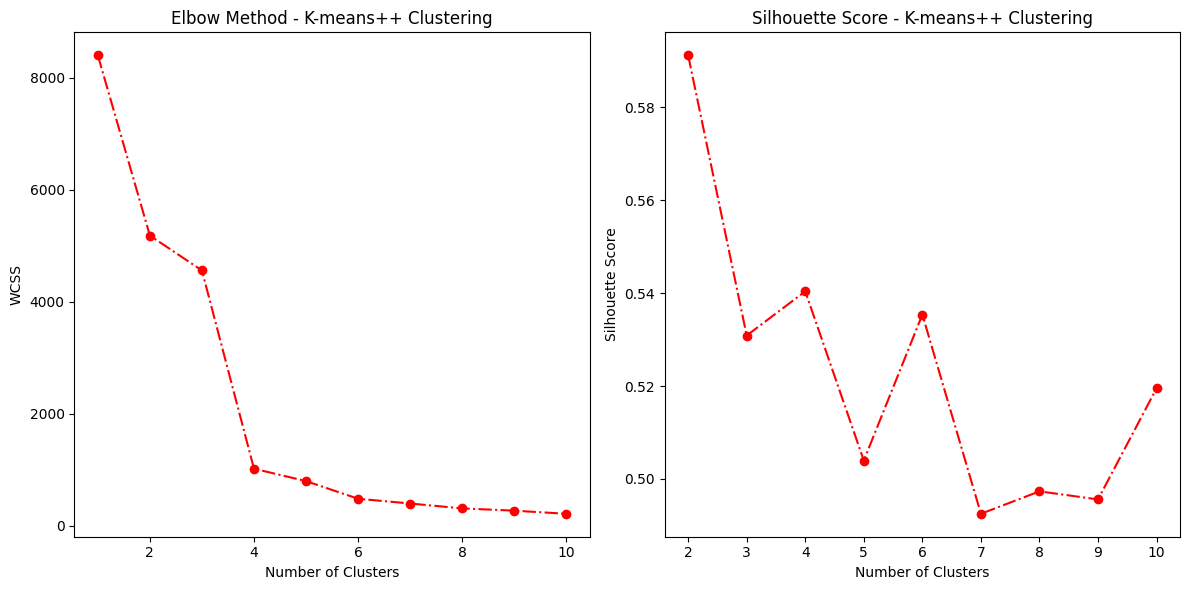

In [73]:
# Generate the WCSS corresponding to number of clusters to identify the most optimal clusters
wcss = []
silhouette_kmeans = []
for i in range (1,11): # calculating the WCSS for 1 to 11 number of clusters
    k_means_iter = KMeans(init = 'k-means++', n_clusters= i, random_state = RSEED)
    k_means_iter.fit(cluster_data_scaled)
    wcss.append(k_means_iter.inertia_)

    # the silhouette score is only valid if there're at least 2 clusters
    if i > 1:
        silhouette_kmeans.append(sklearn.metrics.silhouette_score(cluster_data_scaled, k_means_iter.labels_, metric='euclidean'))
    else:
        silhouette_kmeans.append(None)

# Visualize the 'elbow' method and its silhouette score
plt.figure(figsize = (12,6))

# Check the WCSS plot
plt.subplot(1,2,1)
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method - K-means++ Clustering')

# Check the silhouette score plot
plt.subplot(1,2,2)
plt.plot(range(2, 11), silhouette_kmeans[1:], marker = 'o', linestyle = '-.',color='red') # only plot for k>1
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score - K-means++ Clustering')

plt.tight_layout()
plt.show()

# Based on the elbow method and its silhouette score, the most optimal number of clusters is 4.
# The higher number of clusters may be impractical for marketing initiatives although the silhouette score and WCSS is better.

In [74]:
# Fit the model and predict the cluster labels with k=3
k_means = KMeans(init = "k-means++", n_clusters = 4, random_state = RSEED)
k_means.fit(cluster_data_scaled)


# Step 4: add the k-means label to a new dataframe
df_cluster = pd.DataFrame(cluster_data, columns=numeric_cols)
df_cluster['cluster'] = k_means.labels_

# Step 5: calculate the centroid value of each class
print("k-means clusters center (in standardized space)): \n " + str(k_means.cluster_centers_))

# Since all the parameters were standardized, hence we need to inverse transform the center to the original measurement.
k_means_center = scaler.inverse_transform(k_means.cluster_centers_)
print("k-means clusters center (in original measurement)): \n " + str(k_means_center))

k-means clusters center (in standardized space)): 
 [[-1.04580385 -0.12662958]
 [ 1.25187936  0.1998439 ]
 [ 0.12198817 -0.07440739]
 [ 0.0864487  59.73461783]]
k-means clusters center (in original measurement)): 
 [[-2.18208232e+00  1.29168495e+04]
 [ 2.61206135e+00  9.96217937e+04]
 [ 2.54529788e-01  2.67860379e+04]
 [ 1.80376261e-01  1.59108888e+07]]


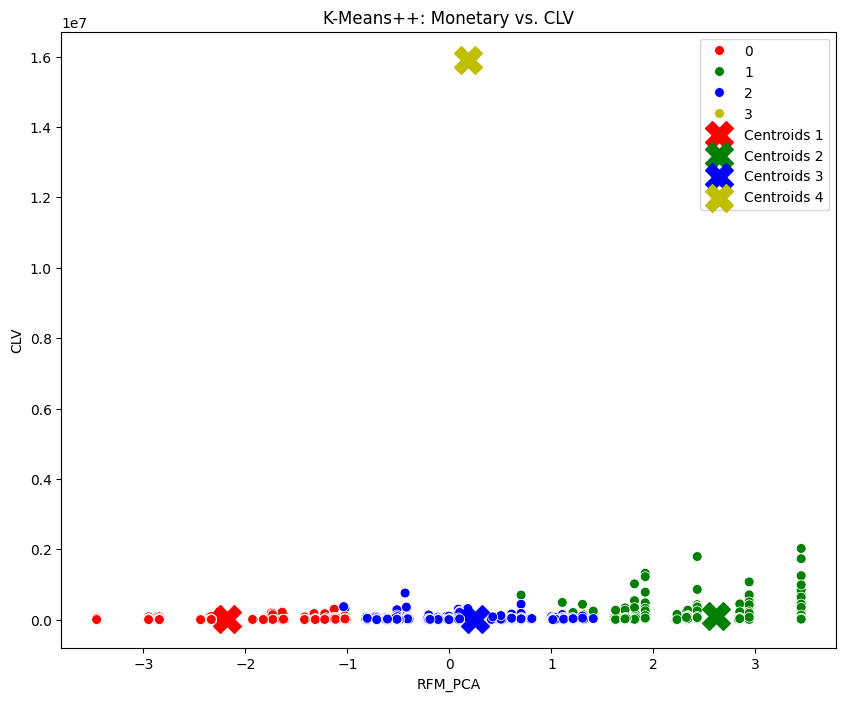

          RFM_PCA           CLV
cluster                        
0       -2.182082  1.291685e+04
1        2.612061  9.962179e+04
2        0.254530  2.678604e+04
3        0.180376  1.591089e+07


In [75]:
# Step 1: visualize the cluster result in a scatter plot of Age and Income
plt.figure(figsize=(10,8))
sns.scatterplot(data = df_cluster, x = 'RFM_PCA', y = 'CLV', hue = 'cluster', palette = ['r', 'g', 'b', 'y'], s=50)
centroid_color = ['r', 'g', 'b', 'y']
for i in range(len(k_means_center)):
    plt.scatter(k_means_center[i, 0], k_means_center[i, 1], s=400, c=centroid_color[i], marker='X', label=f'Centroids {i+1}')
plt.title('K-Means++: Monetary vs. CLV')
plt.xlabel('RFM_PCA')
plt.ylabel('CLV')
plt.legend()
plt.show()

# Descriptive statistics of each cluster
print(df_cluster.groupby(['cluster']).mean())


### DBSCAN


DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm that is especially noted for its effectiveness in identifying clusters of varying shapes and sizes in a data set, while being robust against noise and outliers. This makes DBSCAN particularly useful in real-world data processing where the data may not be uniformly sampled. 

DBSCAN stands apart from centroid-based clustering techniques like K-Means because it doesn’t require a predefined number of clusters. Instead, it uses the spatial density of data points to find clusters. It can identify clusters in large spatial datasets by looking at the local density of data points and grouping points that are closely packed together.


#### Core Concepts of DBSCAN

DBSCAN involves two main parameters:
- **ε (epsilon)**: A distance measure that defines the neighborhood around a data point.
- **MinPts (minimum points)**: The minimum number of points required to form a dense region, which means that for a point to be considered a core point, it must have at least MinPts within its ε-neighborhood.

#### Types of Points in DBSCAN

1. **Core Points**: A point is a core point if at least MinPts points are within distance ε (including the point itself).
2. **Border Points**: A border point has fewer than MinPts within distance ε but is in the neighborhood of a core point.
3. **Noise Points**: A noise point is any point that is not a core point or a border point.

#### Algorithm Steps

1. Label all points as core, border, or noise points.
2. Eliminate noise points.
3. Put an edge between all core points that are within distance ε of each other.
4. Make each group of connected core points into a separate cluster.
5. Assign each border point to one of the clusters of its associated core points.


#### Example Usage

DBSCAN is commonly applied in fields like anomaly detection, spatial data analysis, genetics, and image segmentation. It's particularly effective in scenarios where the clusters are not spherical or where noise can significantly affect the clustering results.



In [76]:
# Setup DBSCAN and evaluate the best parameters of eps and min_sample
silhouette_dbscan = {}
n_cluster = {}
n_noise = {}

# Define parameter grids to find the best parameter for clustering
eps_value = np.arange(0.5,4,0.2)
min_sample_value = np.arange(5,20,2)

data = {'eps': [], 'min_sample' : [], 'n_clusters': [], 'n_noises': [], 'silhouette_values': []}
for eps in eps_value:
    for min_sample in min_sample_value:
        dbscan_iter = DBSCAN(eps = eps, min_samples=min_sample).fit(cluster_data_scaled)
        n_cluster = (len(set(dbscan_iter.labels_)) - (1 if -1 in dbscan_iter.labels_ else 0))
        n_noise = list(dbscan_iter.labels_).count(-1)

        # the silhouette score is only valid if there're at least 2 clusters
        if n_cluster > 1:
            silhouette = sklearn.metrics.silhouette_score(cluster_data_scaled, dbscan_iter.labels_, metric='euclidean')
        else:
            silhouette = -1 #very bad clustering performance

        #put it in the dictionary to create a dataframe later
        data['eps'].append(np.round(eps,2))
        data['min_sample'].append(min_sample)
        data['n_clusters'].append(n_cluster)
        data['n_noises'].append(n_noise)
        data['silhouette_values'].append(silhouette)

# Find the maximum silhouette score:
df_dbscan_grid = pd.DataFrame(data)
print("Step 1: The result of iteration with multiple 'eps' and 'min_sample' parameters")
print(df_dbscan_grid)
print('\n')

print('Step 2: Finding parameter where the Silhouette Value is maximum')
print(df_dbscan_grid[df_dbscan_grid['silhouette_values'] == df_dbscan_grid['silhouette_values'].max()])
print('\n')

Step 1: The result of iteration with multiple 'eps' and 'min_sample' parameters
     eps  min_sample  n_clusters  n_noises  silhouette_values
0    0.5           5           1        15                 -1
1    0.5           7           1        17                 -1
2    0.5           9           1        17                 -1
3    0.5          11           1        21                 -1
4    0.5          13           1        21                 -1
..   ...         ...         ...       ...                ...
139  3.9          11           1         1                 -1
140  3.9          13           1         1                 -1
141  3.9          15           1         1                 -1
142  3.9          17           1         1                 -1
143  3.9          19           1         1                 -1

[144 rows x 5 columns]


Step 2: Finding parameter where the Silhouette Value is maximum
     eps  min_sample  n_clusters  n_noises  silhouette_values
0    0.5           5    

In [77]:
# Using parameter where the best silhouette value performs, fit the model and assign the label
best_eps = df_dbscan_grid.loc[df_dbscan_grid['silhouette_values'].idxmax(), 'eps']
best_min_samples = df_dbscan_grid.loc[df_dbscan_grid['silhouette_values'].idxmax(), 'min_sample']

dbscan_best = DBSCAN(
    eps = float(best_eps),
    min_samples = int(best_min_samples)
).fit(cluster_data_scaled)
dbscan_best_label = dbscan_best.labels_

# List of 'eps' and 'min_sample' that have 3 classes within the parameter grids and find the best silhouette values
print("Step 3: List of 'eps' and 'min_sample' that have 3 clases within parameter grids")
print(df_dbscan_grid[df_dbscan_grid['n_clusters'] == 3])
print('\n')

# Perform DBScan with 3 classes and the best silhouete score and add the labels to the DataFrame
dbscan = DBSCAN(eps = 0.9, min_samples = 9).fit(cluster_data_scaled)
df_cluster['DBScan_cluster'] = dbscan.labels_

Step 3: List of 'eps' and 'min_sample' that have 3 clases within parameter grids
Empty DataFrame
Columns: [eps, min_sample, n_clusters, n_noises, silhouette_values]
Index: []




C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\54088854.py:5: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(data = df_cluster, x = 'RFM_PCA', y = 'CLV', hue = 'DBScan_cluster', palette = ['k','r','g','b'])
C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_6704\54088854.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax[0] = sns.scatterplot(ax = ax[0], data = df_cluster, x = 'RFM_PCA', y = 'CLV', hue = 'DBScan_cluster', palette = ['k','r','g','b'])


                 RFM_PCA           CLV   cluster
DBScan_cluster                                  
-1              1.831708  3.924999e+06  1.500000
 0             -0.002619  4.100257e+04  0.929473


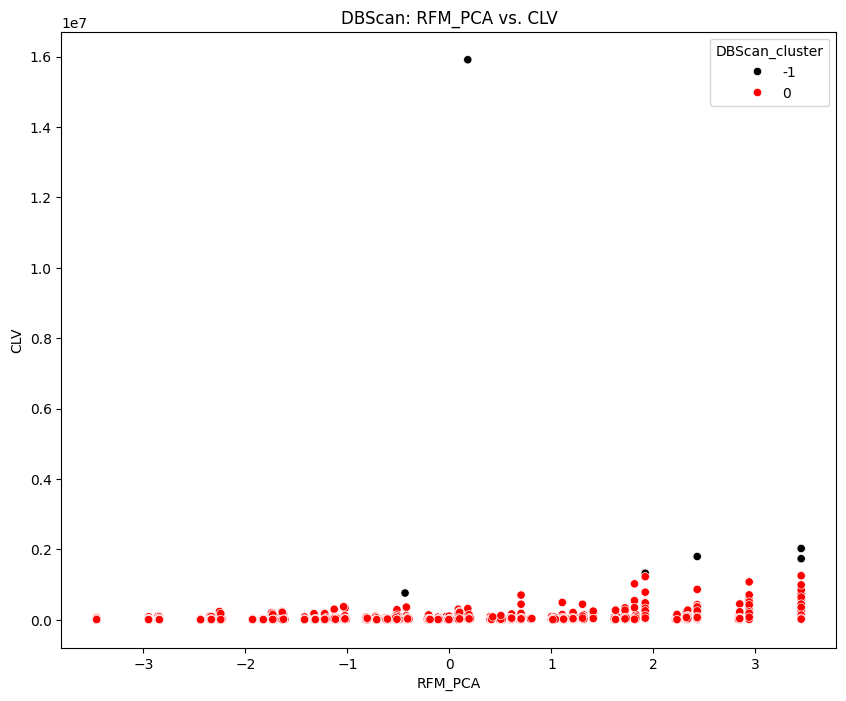

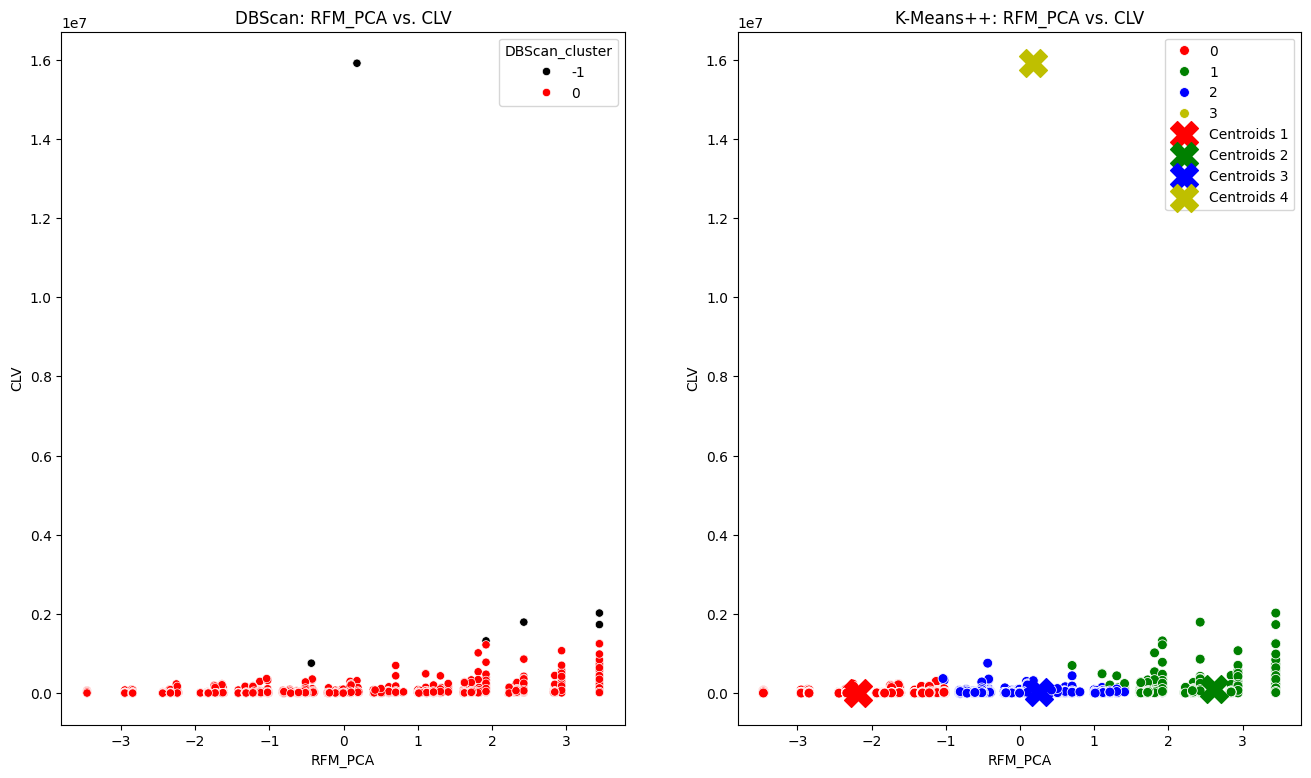

In [78]:
# Write your code here

# Step 1: visualize the cluster result in a scatter plot of Age and Income
plt.figure(figsize=(10,8))
sns.scatterplot(data = df_cluster, x = 'RFM_PCA', y = 'CLV', hue = 'DBScan_cluster', palette = ['k','r','g','b'])
plt.title('DBScan: RFM_PCA vs. CLV')

# Descriptive statistics of each cluster
print(df_cluster.groupby(['DBScan_cluster']).mean())

# Step 2: compare the results between DBScan and K-Means
fig , ax = plt.subplots(1, 2, figsize=(16,9))

# DBScan
ax[0] = sns.scatterplot(ax = ax[0], data = df_cluster, x = 'RFM_PCA', y = 'CLV', hue = 'DBScan_cluster', palette = ['k','r','g','b'])
ax[0].set_title('DBScan: RFM_PCA vs. CLV')

# K-Means++
ax[1] = sns.scatterplot(data = df_cluster, x = 'RFM_PCA', y = 'CLV', hue = 'cluster', palette = ['r', 'g', 'b', 'y'], s=50)
centroid_color = ['r', 'g', 'b', 'y']
for i in range(len(k_means_center)):
    ax[1].scatter(k_means_center[i, 0], k_means_center[i, 1], s=400, c=centroid_color[i], marker='X', label=f'Centroids {i+1}')
ax[1].set_title('K-Means++: RFM_PCA vs. CLV')
ax[1].legend()

plt.show()

<h2 id="#Silhouette_coefficient">Silhouette coefficient</h2>

The Silhouette Coefficient is a metric used to evaluate the quality of a clustering algorithm. It measures how similar an object is to its own cluster compared to other clusters. The Silhouette Coefficient provides a succinct graphical representation of how well each object has been classified.

## Definition of the Silhouette Coefficient

The Silhouette Coefficient for a single sample is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The formula is as follows:

$$ s = \frac{b - a}{\max(a, b)} $$

Where:
- $ a $ is the average distance between a sample and all other points in the same cluster.
- $ b $ is the average distance between a sample and all other points in the nearest cluster that the sample is not a part of.

### Interpretation of the Silhouette Coefficient

- **Value Range**: The coefficient can range from -1 to 1.
  - A value of 1 indicates that the sample is far away from the neighboring cluster.
  - A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
  - A value of -1 indicates that the sample has been assigned to the wrong cluster.

### Uses of the Silhouette Coefficient

The Silhouette Coefficient is particularly useful for determining:
- **Cluster Cohesion and Separation**: It provides insight into the degree to which data points are appropriately grouped.
- **Optimal Number of Clusters**: By calculating the Silhouette Coefficient for several values of k, you can plot these scores to determine the best number of clusters in a dataset.



In [79]:
from sklearn.metrics import silhouette_score

# Write your code here
print('Silhouette Score for DBScan', sklearn.metrics.silhouette_score(cluster_data_scaled, dbscan.labels_, metric='euclidean'))
print('Silhouette Score for K-Means++', sklearn.metrics.silhouette_score(cluster_data_scaled, k_means.labels_, metric='euclidean'))

Silhouette Score for DBScan 0.9152468791310874
Silhouette Score for K-Means++ 0.5403678587263002


#### The strengths and weaknessess of each clustering method.

##### K-Means++
-. Strength: can input expected number of cluster (which is easily tailored with the need), produce higher silhouette score, less computational expensive, all the data points are assigned to the cluster <br>
-. Weakness: product relatively diverse customers background with similar behavior

##### DBScan
-. Strength: produce more similar audience within the clusters <br>
-. Weakness: cannot input expected number of cluster, with wrong placed parameters can't achieve higher silhouette score, more computational expensive (especially when fine-tuning parameters), produce noise cluster which may cause loss information.

## The End